In [2]:
# Import core
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt 
import re
import gc
import string
from IPython.core.interactiveshell import InteractiveShell

# Import custom
from datetime import datetime, timedelta
#from plotnine import *
from pandas.api.types import CategoricalDtype
#from plotnine.data import mpg
#%matplotlib inline

# Import NLTK related
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import ne_chunk, pos_tag
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.util import ngrams

# Import visualization
import seaborn as sns
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import iplot
import chart_studio.plotly.plotly as py
import cufflinks

# Import keras
from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation, Embedding, LSTM, SpatialDropout1D, Dropout
#from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

# Import web-related
from bs4 import BeautifulSoup

# Import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [3]:
import psutil
psutil.virtual_memory()

svmem(total=17179869184, available=8570343424, percent=50.1, used=8608083968, free=1598541824, active=6389297152, inactive=3765645312, wired=2218786816)

# Definitions

In [4]:
# Remove digits from location data so we have "City, State" format
def remove_digits(df):
    """Remove digits from location"""
    df["Location_Clean"] = df["Location"].replace(to_replace = r'\d', value='', regex=True).str.rstrip()
    
    return df


# Create a day index which will be used to calcultate when the job was posted
def day_index(df):
    """Create a day index that represents how long ago the job was posted """
    
    df_dummy = pd.DataFrame()
    df_dummy["Day Index"] = df["Date"].str.split(" ", expand=True).get(0)
    df["Day Index"] = df_dummy["Day Index"].apply(lambda x: 0 if (x == 'Just' or x == 'Today') else x)
    
    return df

# Create variables representing the week date range and week index in which the job was posted
def week_posted(df):
    """Create a variable representing the week in which the job was posted"""
    conditions_date = [
        (df['Date Posted'] >= datetime(2020, 3, 4)) & (df['Date Posted'] <= datetime(2020, 3, 7)),
        (df['Date Posted'] >= datetime(2020, 3, 8)) & (df['Date Posted'] <= datetime(2020, 3, 14)),
        (df['Date Posted'] >= datetime(2020, 3, 15)) & (df['Date Posted'] <= datetime(2020, 3, 21)),
        (df['Date Posted'] >= datetime(2020, 3, 22)) & (df['Date Posted'] <= datetime(2020, 3, 28)),
        (df['Date Posted'] >= datetime(2020, 3, 29)) & (df['Date Posted'] <= datetime(2020, 4, 4)),
        (df['Date Posted'] >= datetime(2020, 4, 5)) & (df['Date Posted'] <= datetime(2020, 4, 11)),
        (df['Date Posted'] >= datetime(2020, 4, 12)) & (df['Date Posted'] <= datetime(2020, 4, 18))]
    
    conditions_index = [
        (df['Date Posted'] >= datetime(2020, 3, 4)) & (df['Date Posted'] <= datetime(2020, 3, 7)),
        (df['Date Posted'] >= datetime(2020, 3, 8)) & (df['Date Posted'] <= datetime(2020, 3, 14)),
        (df['Date Posted'] >= datetime(2020, 3, 15)) & (df['Date Posted'] <= datetime(2020, 3, 21)),
        (df['Date Posted'] >= datetime(2020, 3, 22)) & (df['Date Posted'] <= datetime(2020, 3, 28)),
        (df['Date Posted'] >= datetime(2020, 3, 29)) & (df['Date Posted'] <= datetime(2020, 4, 4)),
        (df['Date Posted'] >= datetime(2020, 4, 5)) & (df['Date Posted'] <= datetime(2020, 4, 11)),
        (df['Date Posted'] >= datetime(2020, 4, 12)) & (df['Date Posted'] <= datetime(2020, 4, 18))]
    
    
    
    choices_date = ['Mar 1 - Mar 7','Mar 8 - Mar 14', 'Mar 15 - Mar 21', 'Mar 22 - Mar 28', 'Mar 29 - Apr 4', 'Apr 5 - Apr 11', 'Apr 12 - Apr 18']
    choices_index = [0, 1, 2, 3, 4, 5, 6]

    df['Week Posted'] = np.select(conditions_date, choices_date)
    df['Week Index'] = np.select(conditions_index, choices_index)
    return df


## Import merged dataset

In [5]:
df_usa = pd.read_csv('df_usa_april_week3_merged_no30days.csv')

df_usa['As of Date'] = pd.to_datetime(df_usa['As of Date'])
df_usa['Date Posted'] = pd.to_datetime(df_usa['Date Posted'])

df_usa.head()
#df_usa.pipe(week_posted).head()

Title              Location  \
0              Data Scientist Analyst         Sunnyvale, CA   
1  Data Science Intern (Summer, 2020)  Westfield Center, OH   
2                 Data Science Intern         San Diego, CA   
3                      Data Scientist                Remote   
4                      Data Scientist          Richland, WA   

                                 Company Rating Salary Sponsored        Date  \
0            LOCKHEED MARTIN CORPORATION    4.0   None      None  2 days ago   
1                    Westfield Insurance    4.0   None      None   1 day ago   
2                                     HP    4.0   None      None  2 days ago   
3                        Imperfect Foods    2.9   None      None  4 days ago   
4  Pacific Northwest National Laboratory    4.1   None      None   1 day ago   

  As of Date                                        Description     Industry  \
0 2020-04-26  Perform exploratory research and analysis to i...  Datascience   
1 2020-04-26  BUILD YOUR FUTURE, WHILE PROTECTING THEIRS.\nY...  Datascience   
2 2020-04-26  Join us for a 12 week paid internship for the ...  Datascience   
3 2020-04-26  About Imperfect\n\nImperfect Foods was founded...  Datascience   
4 2020-04-26  Organization and Job ID\nJob ID: 310781\nDirec...  Datascience   

   Day Index Date Posted      Week Posted  Week Index  
0        2.0  2020-04-24  Apr 19 - Apr 25           7  
1        1.0  2020-04-25  Apr 19 - Apr 25           7  
2        2.0  2020-04-24  Apr 19 - Apr 25           7  
3        4.0  2020-04-22  Apr 19 - Apr 25           7  
4        1.0  2020-04-25  Apr 19 - Apr 25           7

## NLP on Job Description

In [6]:
### 5 - Description
#sents = sent_tokenize(df1["Description"][1])
#words = word_tokenize(df1["Description"][1])

In [7]:
def lower_tokens(df):
    """Convert descriptions to lower case and then tokenize them"""
    description_lower = df["Description"].apply(lambda x: x.lower())
    df["Tokens"] = description_lower.apply(lambda x: nltk.word_tokenize(x))    
    return df

def sentence(df):
    description_lower = df["Description"].apply(lambda x: x.lower())
    df["Sentence"] = description_lower.apply(lambda x: sent_tokenize(x))
    return df

In [8]:
# Takes about Duration: 0:00:59.713260
df_usa.pipe(lower_tokens).head(1)

Title       Location                      Company Rating  \
0  Data Scientist Analyst  Sunnyvale, CA  LOCKHEED MARTIN CORPORATION    4.0   

  Salary Sponsored        Date As of Date  \
0   None      None  2 days ago 2020-04-26   

                                         Description     Industry  Day Index  \
0  Perform exploratory research and analysis to i...  Datascience        2.0   

  Date Posted      Week Posted  Week Index  \
0  2020-04-24  Apr 19 - Apr 25           7   

                                              Tokens  
0  [perform, exploratory, research, and, analysis...

In [9]:
# Takes about Duration: 0:00:15
df_usa.pipe(sentence).head(1)

Title       Location                      Company Rating  \
0  Data Scientist Analyst  Sunnyvale, CA  LOCKHEED MARTIN CORPORATION    4.0   

  Salary Sponsored        Date As of Date  \
0   None      None  2 days ago 2020-04-26   

                                         Description     Industry  Day Index  \
0  Perform exploratory research and analysis to i...  Datascience        2.0   

  Date Posted      Week Posted  Week Index  \
0  2020-04-24  Apr 19 - Apr 25           7   

                                              Tokens  \
0  [perform, exploratory, research, and, analysis...   

                                            Sentence  
0  [perform exploratory research and analysis to ...

In [10]:
skills_df = df_usa.filter(items=["Title", "Location", "Company", "Industry", "Sentence", "Description"])
skills_df.head(1)

Title       Location                      Company  \
0  Data Scientist Analyst  Sunnyvale, CA  LOCKHEED MARTIN CORPORATION   

      Industry                                           Sentence  \
0  Datascience  [perform exploratory research and analysis to ...   

                                         Description  
0  Perform exploratory research and analysis to i...

In [11]:
skills_df["sent_skills"] = ""

for i in skills_df.index:
    sentence = skills_df["Sentence"][i]
    
    for line in sentence:
        skills = []
        if "skills" in line:
            skills.append(line)
            skills_df["sent_skills"][i] = ' '.join(map(str, skills))
        
skills_df.head(1)

Title       Location                      Company  \
0  Data Scientist Analyst  Sunnyvale, CA  LOCKHEED MARTIN CORPORATION   

      Industry                                           Sentence  \
0  Datascience  [perform exploratory research and analysis to ...   

                                         Description  \
0  Perform exploratory research and analysis to i...   

                                         sent_skills  
0  desired skills:\npython\nc++\ndata engineering...

In [12]:
def lower_tokens(df):
    """Convert descriptions to lower case and then tokenize them"""
    df["Tokens"] = skills_df["sent_skills"].apply(lambda x: nltk.word_tokenize(x))
    
    return df

In [13]:
skills_df.pipe(lower_tokens).head(1)

Title       Location                      Company  \
0  Data Scientist Analyst  Sunnyvale, CA  LOCKHEED MARTIN CORPORATION   

      Industry                                           Sentence  \
0  Datascience  [perform exploratory research and analysis to ...   

                                         Description  \
0  Perform exploratory research and analysis to i...   

                                         sent_skills  \
0  desired skills:\npython\nc++\ndata engineering...   

                                              Tokens  
0  [desired, skills, :, python, c++, data, engine...

In [14]:
punctuation = string.punctuation 
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [15]:
start_time = datetime.now()

stop_words=set(stopwords.words('english'))

skills_df["Tokens_wo_stop"] = ""

for i in skills_df.index:
    filtered_sent = []
    for w in skills_df["Tokens"][i]:        
        if w not in stop_words:
            filtered_sent.append(w)
            skills_df["Tokens_wo_stop"][i] = filtered_sent
            
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:58.941510


In [16]:
def skills_tokens (df):
    total_skills = total_skills + df["Tokens_wo_stop"]
    return total_skills

In [17]:
statistics=['statistical models','statistical modeling','probability','normal distribution','poisson distribution',
            'survival models','hypothesis testing','bayesian testing','factor analysis','forecasting',
           'markov chain','monte carlo']

machine_learning=['machine learning', 'regression', 'classification', 'clustering', 'logistic', 'K means', 'random forest', 'xgboost', 'svm', 
                 'naive bayes', 'pca', 'decision trees', 'svd', 'ensemble models', 'boltzman machine']

data_engineering=['aws', 'ec2','spark','s3','docker','kubernetes','scala','teradata','google big query',
                  'hive','hadoop','sql']

deep_learning=['neural', 'keras','theano','face detection','convolutional','object detection','yolo','gpu','cuda',
                  'tensorflow','lstm','gan', 'opencv']

r_language=['r', 'ggplot','shiny','cran','dplyr','tidyr','lubridate','knitr']
            
python_language=['python', 'flask','django','pandas','numpy','skitlearn','sklearn','matplotlib',
                'scipy', 'bokeh','statsmodel']

nlp=['nlp', 'lda','lsi','spacy','nltk']
            

# Start the new model from here. Work only with datascience jobs

In [18]:
df_ds = df_usa.copy()[df_usa["Industry"] == "Datascience"]
df_ds.head(1)

Title       Location                      Company Rating  \
0  Data Scientist Analyst  Sunnyvale, CA  LOCKHEED MARTIN CORPORATION    4.0   

  Salary Sponsored        Date As of Date  \
0   None      None  2 days ago 2020-04-26   

                                         Description     Industry  Day Index  \
0  Perform exploratory research and analysis to i...  Datascience        2.0   

  Date Posted      Week Posted  Week Index  \
0  2020-04-24  Apr 19 - Apr 25           7   

                                              Tokens  \
0  [perform, exploratory, research, and, analysis...   

                                            Sentence  
0  [perform exploratory research and analysis to ...

In [19]:
## Functions

punctuation = '!"#$%\'()*,-:;<=>?@[\\]^_`{|}~'

def sentence(df):
    description_clean = df["Description"].apply(lambda x: x.replace("\n", " "))
    description_lower = description_clean.apply(lambda x: x.lower())
    description_lower_no_punctuation = description_lower.apply(lambda x: x.translate(str.maketrans('', '', punctuation)))
    df["Sentence"] = description_lower_no_punctuation.apply(lambda x: sent_tokenize(x))
    return df

In [21]:
df_ds.pipe(sentence).head(1)

Title       Location                      Company Rating  \
0  Data Scientist Analyst  Sunnyvale, CA  LOCKHEED MARTIN CORPORATION    4.0   

  Salary Sponsored        Date As of Date  \
0   None      None  2 days ago 2020-04-26   

                                         Description     Industry  Day Index  \
0  Perform exploratory research and analysis to i...  Datascience        2.0   

  Date Posted      Week Posted  Week Index  \
0  2020-04-24  Apr 19 - Apr 25           7   

                                              Tokens  \
0  [perform, exploratory, research, and, analysis...   

                                            Sentence  
0  [perform exploratory research and analysis to ...

# Filter data on all possible NOUNS in a sentence

In [20]:
tokenized = []
for i in df_ds.index:
    tokenized = tokenized + df_ds.Sentence[i]
    
tokenized[2]

': gpu processing, distributed computing, highly parallel coding, cloud computing, machine learning, visualization, system modelling and simulation) to achieve results.'

In [937]:
nouns_array = []

for i in tokenized:
    nouns_list = []

    
    words = nltk.word_tokenize(i)
    tagged = nltk.pos_tag(words)
    for word in tagged:
        if 'NN' in word[1]:
            nouns_list.append(word[0])
            nouns_list_join = ' '.join(map(str,nouns_list))
            
    nouns_array.append(nouns_list_join)
    
nouns_array


['research analysis patterns data methods hypotheses relationships factors work business value',
 'combination technologies systems i.e',
 'gpu processing machine visualization system simulation results',
 'areas expertise statistics language processing learning optimization fields',
 'work datasets statistics machine learning algorithms use exploratory data analysis techniques relationships patterns trends data sets discover opportunities datasets models algorithms data / business problems math statistics models extrapolate prescribe data recommendations visualizations qualifications bachelors college mathematics science engineering years experience data science data analytics experience masters',
 'learner',
 'skills data engineering sw hw architecture qualifications job.qualifications martin action employer',
 'applicants consideration employment regard race color religion sex pregnancy orientation gender identity origin age status disability status',
 'lockheed martin mission',
 'c

In [948]:
with open('fullnounsarray_jun22.txt', 'w') as filehandle:
    filehandle.writelines("%s\n" % place for place in nouns_array)

## Chunk each sentence

In [53]:
chunking_list = []
def chunking():
    
    start_time = datetime.now()
        
    try:
        for i in tokenized:
            words = nltk.word_tokenize(i)
            tagged = nltk.pos_tag(words)
            
            chunkGram = r"""Chunk: {<NN.*>+}"""
            
            chunkParser = nltk.RegexpParser(chunkGram)
            chunked = chunkParser.parse(tagged)
            for subtree in chunked.subtrees():
                if subtree.label() == 'Chunk': 
                    chunking_list.append(subtree)
                    #print(subtree)
                    
    except Exception as e:
        print(str(e))

    end_time = datetime.now()
    print('Duration: {}'.format(end_time - start_time))
        
chunking()

Duration: 0:01:12.734832


# Combining chunks by "_"

In [318]:
chunking_array = []

for i in tokenized[:1]:
    
    words = nltk.word_tokenize(i)
    tagged = nltk.pos_tag(words)
            
    chunkGram = r"""Chunk: {<NN.*>+}"""
            
    chunkParser = nltk.RegexpParser(chunkGram)
    chunked = chunkParser.parse(tagged)

    chunking_list = []
    for subtree in chunked.subtrees():
        if subtree.label() == 'Chunk': 
            chunking_list.append(subtree.leaves())
            chunking_list_join = ' '.join(map(str,chunking_list))
        
            characters_to_remove = "(),S'"
            new_string = chunking_list_join
            for character in characters_to_remove:
                new_string = new_string.replace(character, "")
        
            new_string = new_string.replace(" NN ", "_")
            new_string = new_string.replace(" NN]", "")
            chunking_list_join = new_string.replace("[", "")
    
    chunking_array.append(chunking_list_join)
        

In [317]:
tagged

[('desired', 'VBN'),
 ('skills', 'NNS'),
 (':', ':'),
 ('python', 'NN'),
 ('c++', 'NN'),
 ('data', 'NNS'),
 ('engineering', 'NN'),
 ('sw', 'NN'),
 ('&', 'CC'),
 ('hw', 'NN'),
 ('architecture', 'NN'),
 ('aws', 'VBZ'),
 ('cuda', 'JJ'),
 ('basic', 'JJ'),
 ('qualifications', 'NNS'),
 (':', ':'),
 ('job.qualifications', 'NNS'),
 ('lockheed', 'VBP'),
 ('martin', 'NN'),
 ('is', 'VBZ'),
 ('an', 'DT'),
 ('equal', 'JJ'),
 ('opportunity/affirmative', 'JJ'),
 ('action', 'NN'),
 ('employer', 'NN'),
 ('.', '.')]

In [281]:
with open('chunks_combined_jun22.txt', 'w') as filehandle:
    filehandle.writelines("%s\n" % place for place in chunking_array)

In [24]:
#df_chunk = pd.DataFrame(chunking_list)
#print(df_chunk.shape)

(220702, 17)


# Testing Array Iteration

In [264]:
test = tokenized[6]
test

'desired skills:\npython\nc++\ndata engineering\nsw & hw architecture\naws\ncuda\nbasic qualifications:\njob.qualifications\n\nlockheed martin is an equal opportunity/affirmative action employer.'

In [278]:
words = nltk.word_tokenize(test)
tagged = nltk.pos_tag(words)
            
chunkGram = r"""Chunk: {<NN.*>+}"""
            
chunkParser = nltk.RegexpParser(chunkGram)
chunked = chunkParser.parse(tagged)

In [279]:
tagged

[('desired', 'VBN'),
 ('skills', 'NNS'),
 (':', ':'),
 ('python', 'NN'),
 ('c++', 'NN'),
 ('data', 'NNS'),
 ('engineering', 'NN'),
 ('sw', 'NN'),
 ('&', 'CC'),
 ('hw', 'NN'),
 ('architecture', 'NN'),
 ('aws', 'VBZ'),
 ('cuda', 'JJ'),
 ('basic', 'JJ'),
 ('qualifications', 'NNS'),
 (':', ':'),
 ('job.qualifications', 'NNS'),
 ('lockheed', 'VBP'),
 ('martin', 'NN'),
 ('is', 'VBZ'),
 ('an', 'DT'),
 ('equal', 'JJ'),
 ('opportunity/affirmative', 'JJ'),
 ('action', 'NN'),
 ('employer', 'NN'),
 ('.', '.')]

In [280]:
chunk_list = []
chunk_array = []

for subtree in chunked.subtrees():
    if subtree.label() == 'Chunk':
        
        chunk_list.append(subtree.leaves())
        chunk_array = np.array(chunk_list)
        
chunk_array

array([list([('skills', 'NNS')]),
       list([('python', 'NN'), ('c++', 'NN'), ('data', 'NNS'), ('engineering', 'NN'), ('sw', 'NN')]),
       list([('hw', 'NN'), ('architecture', 'NN')]),
       list([('qualifications', 'NNS')]),
       list([('job.qualifications', 'NNS')]), list([('martin', 'NN')]),
       list([('action', 'NN'), ('employer', 'NN')])], dtype=object)

In [313]:
subtrees()

NameError: name 'subtrees' is not defined

In [281]:
chunk_list = []
nouns_list = []
nouns_list_array = []

for chunk in chunk_array:

    if len(chunk) == 1:
        for word in chunk:
            chunk_list.append(word[0])
    else:
        nouns_array = np.array(chunk)
        transpose_list = nouns_array.T[0]
        transpose_list_combined = '_'.join(map(str,transpose_list))
        #print(transpose_list_combined)
        chunk_list.append(transpose_list_combined)
        #print(nouns_array.size)
        #    i = i+1
            
        #for word in chunk:
        #    chunk_list.append(word[0])
        #for word in chunk:
         #   print(word)
             
                #chunk_list.append(word[0])
        
        #'_'.join(map(str,chunk_list))
    #else:
     #   chunk_list.append(word[0])
                
chunk_list

['skills',
 'python_c++_data_engineering_sw',
 'hw_architecture',
 'qualifications',
 'job.qualifications',
 'martin',
 'action_employer']

In [308]:
full_chunk_list =[]
chunk_list = []
for i in tokenized[3]:
    
    words = nltk.word_tokenize(test)
    tagged = nltk.pos_tag(words)
            
    chunkGram = r"""Chunk: {<NN.*>+}"""
            
    chunkParser = nltk.RegexpParser(chunkGram)
    chunked = chunkParser.parse(tagged)

    chunk_list = []
    chunk_array = []

    for subtree in chunked.subtrees():
        if subtree.label() == 'Chunk':
        
            chunk_list.append(subtree.leaves())
            chunk_array = np.array(chunk_list)
        
            nouns_list = []
            nouns_list_array = []
            
            #for chunk in chunk_array:
              #  print(chunk_array.size)

               # if len(chunk) == 1:
                #    for word in chunk:
                 #       chunk_list.append(word[0])
            #    else:
            #        nouns_array = np.array(chunk)
            #        transpose_list = nouns_array.T[0]
            #        transpose_list_combined = '_'.join(map(str,transpose_list))
            #        chunk_list.append(transpose_list_combined)
       
   # full_chunk_list.append(chunk_list)
    
#full_chunk_list

[list([('skills', 'NNS')])
 list([('python', 'NN'), ('c++', 'NN'), ('data', 'NNS'), ('engineering', 'NN'), ('sw', 'NN')])
 list([('hw', 'NN'), ('architecture', 'NN')])
 list([('qualifications', 'NNS')]) list([('job.qualifications', 'NNS')])
 list([('martin', 'NN')]) list([('action', 'NN'), ('employer', 'NN')])]
[list([('skills', 'NNS')])
 list([('python', 'NN'), ('c++', 'NN'), ('data', 'NNS'), ('engineering', 'NN'), ('sw', 'NN')])
 list([('hw', 'NN'), ('architecture', 'NN')])
 list([('qualifications', 'NNS')]) list([('job.qualifications', 'NNS')])
 list([('martin', 'NN')]) list([('action', 'NN'), ('employer', 'NN')])]
[list([('skills', 'NNS')])
 list([('python', 'NN'), ('c++', 'NN'), ('data', 'NNS'), ('engineering', 'NN'), ('sw', 'NN')])
 list([('hw', 'NN'), ('architecture', 'NN')])
 list([('qualifications', 'NNS')]) list([('job.qualifications', 'NNS')])
 list([('martin', 'NN')]) list([('action', 'NN'), ('employer', 'NN')])]
[list([('skills', 'NNS')])
 list([('python', 'NN'), ('c++', '

[list([('skills', 'NNS')])
 list([('python', 'NN'), ('c++', 'NN'), ('data', 'NNS'), ('engineering', 'NN'), ('sw', 'NN')])
 list([('hw', 'NN'), ('architecture', 'NN')])
 list([('qualifications', 'NNS')]) list([('job.qualifications', 'NNS')])
 list([('martin', 'NN')]) list([('action', 'NN'), ('employer', 'NN')])]
[list([('skills', 'NNS')])
 list([('python', 'NN'), ('c++', 'NN'), ('data', 'NNS'), ('engineering', 'NN'), ('sw', 'NN')])
 list([('hw', 'NN'), ('architecture', 'NN')])
 list([('qualifications', 'NNS')]) list([('job.qualifications', 'NNS')])
 list([('martin', 'NN')]) list([('action', 'NN'), ('employer', 'NN')])]
[list([('skills', 'NNS')])
 list([('python', 'NN'), ('c++', 'NN'), ('data', 'NNS'), ('engineering', 'NN'), ('sw', 'NN')])
 list([('hw', 'NN'), ('architecture', 'NN')])
 list([('qualifications', 'NNS')]) list([('job.qualifications', 'NNS')])
 list([('martin', 'NN')]) list([('action', 'NN'), ('employer', 'NN')])]
[list([('skills', 'NNS')])
 list([('python', 'NN'), ('c++', '

[list([('skills', 'NNS')])
 list([('python', 'NN'), ('c++', 'NN'), ('data', 'NNS'), ('engineering', 'NN'), ('sw', 'NN')])
 list([('hw', 'NN'), ('architecture', 'NN')])
 list([('qualifications', 'NNS')]) list([('job.qualifications', 'NNS')])
 list([('martin', 'NN')]) list([('action', 'NN'), ('employer', 'NN')])]
[list([('skills', 'NNS')])
 list([('python', 'NN'), ('c++', 'NN'), ('data', 'NNS'), ('engineering', 'NN'), ('sw', 'NN')])
 list([('hw', 'NN'), ('architecture', 'NN')])
 list([('qualifications', 'NNS')]) list([('job.qualifications', 'NNS')])
 list([('martin', 'NN')]) list([('action', 'NN'), ('employer', 'NN')])]
[list([('skills', 'NNS')])
 list([('python', 'NN'), ('c++', 'NN'), ('data', 'NNS'), ('engineering', 'NN'), ('sw', 'NN')])
 list([('hw', 'NN'), ('architecture', 'NN')])
 list([('qualifications', 'NNS')]) list([('job.qualifications', 'NNS')])
 list([('martin', 'NN')]) list([('action', 'NN'), ('employer', 'NN')])]
[list([('skills', 'NNS')])
 list([('python', 'NN'), ('c++', '

[list([('skills', 'NNS')])
 list([('python', 'NN'), ('c++', 'NN'), ('data', 'NNS'), ('engineering', 'NN'), ('sw', 'NN')])
 list([('hw', 'NN'), ('architecture', 'NN')])
 list([('qualifications', 'NNS')]) list([('job.qualifications', 'NNS')])
 list([('martin', 'NN')]) list([('action', 'NN'), ('employer', 'NN')])]
[list([('skills', 'NNS')])
 list([('python', 'NN'), ('c++', 'NN'), ('data', 'NNS'), ('engineering', 'NN'), ('sw', 'NN')])
 list([('hw', 'NN'), ('architecture', 'NN')])
 list([('qualifications', 'NNS')]) list([('job.qualifications', 'NNS')])
 list([('martin', 'NN')]) list([('action', 'NN'), ('employer', 'NN')])]
[list([('skills', 'NNS')])
 list([('python', 'NN'), ('c++', 'NN'), ('data', 'NNS'), ('engineering', 'NN'), ('sw', 'NN')])
 list([('hw', 'NN'), ('architecture', 'NN')])
 list([('qualifications', 'NNS')]) list([('job.qualifications', 'NNS')])
 list([('martin', 'NN')]) list([('action', 'NN'), ('employer', 'NN')])]
[list([('skills', 'NNS')])
 list([('python', 'NN'), ('c++', '

In [304]:
for chunk in chunk_array:
    print(chunk)

[('skills', 'NNS')]
[('python', 'NN'), ('c++', 'NN'), ('data', 'NNS'), ('engineering', 'NN'), ('sw', 'NN')]
[('hw', 'NN'), ('architecture', 'NN')]
[('qualifications', 'NNS')]
[('job.qualifications', 'NNS')]
[('martin', 'NN')]
[('action', 'NN'), ('employer', 'NN')]


In [119]:
for chunk in chunk_array:
    chunk_list = []
    if len(chunk) >1:
        for word in chunk:
            chunk_list.append(word[0])
            '_'.join(map(str,chunk_list))
            
print(chunk_list)

[]


In [99]:
chunk_list = []
chunk_array = []
for subtree in chunked.subtrees():
    if subtree.label() == 'Chunk':
        chunk_list.append(subtree.leaves())
        chunk_array = np.array(chunk_list)
        
        for chunk in chunk_array:
            chunk_list = []
            if len(chunk) >1:
                for word in chunk:
                    chunk_list.append(word[0])
                
                '_'.join(map(str,chunk_list))
            else:
                chunk_list.append(word[0])
        
chunk_list

['g']

In [107]:
chunked

The Ghostscript executable isn't found.
See http://web.mit.edu/ghostscript/www/Install.htm
If you're using a Mac, you can try installing
https://docs.brew.sh/Installation then `brew install ghostscript`


LookupError: 

Tree('S', [Tree('Chunk', [('areas', 'NNS')]), ('of', 'IN'), Tree('Chunk', [('expertise', 'NN')]), ('should', 'MD'), ('include', 'VB'), ('several', 'JJ'), ('of', 'IN'), ('the', 'DT'), ('following', 'JJ'), (':', ':'), ('applied', 'JJ'), Tree('Chunk', [('statistics', 'NNS')]), (',', ','), Tree('Chunk', [('text', 'NN'), ('mining', 'NN')]), (',', ','), ('natural', 'JJ'), Tree('Chunk', [('language', 'NN'), ('processing', 'NN')]), (',', ','), ('deep', 'JJ'), Tree('Chunk', [('learning', 'NN')]), (',', ','), Tree('Chunk', [('optimization', 'NN')]), (',', ','), ('and', 'CC'), ('other', 'JJ'), ('similar', 'JJ'), Tree('Chunk', [('fields', 'NNS')]), ('.', '.')])

In [65]:
test = []
for subtree in chunked.subtrees():
    if subtree.label() == 'Chunk':
        test.append(subtree.leaves())

In [77]:
test_2 = np.array(test)
type(test_2)

numpy.ndarray

In [87]:
test = []

for i in test_2:
    if len(i) >1:
        for j in i:
            test.append(j[0])
        
        print(test)

['business', 'value']


In [93]:
'_'.join(map(str,test))

'business_value'

## Investigate chunk data

In [25]:
#df_chunk = pd.read_csv("datascience_chunks_may16.csv")
df_chunk.head(1)

0     1     2     3     4     5     6     7     8     9    10  \
0  (research, NN)  None  None  None  None  None  None  None  None  None  None   

     11    12    13    14    15    16  
0  None  None  None  None  None  None

In [26]:
df_chunk_v2 = df_chunk.copy()[df_chunk[5].isna() == True]
df_chunk_v2.shape

(219249, 17)

In [27]:
df_chunk_v2 = df_chunk_v2.drop(columns = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])
df_chunk_v2.head(1)

0     1     2     3     4
0  (research, NN)  None  None  None  None

In [30]:
def clean_chunk_data(df):
        """Convert df_chunk variables into correct format"""
        df["word_1"] = df[0].apply(lambda x: '' if x is None else x[0])
        df["word_2"] = df[1].apply(lambda x: '' if x is None else x[0])
        df["word_3"] = df[2].apply(lambda x: '' if x is None else x[0])
        df["word_4"] = df[3].apply(lambda x: '' if x is None else x[0])
        df["word_5"] = df[4].apply(lambda x: '' if x is None else x[0])
        #df["word_6"] = df[5].apply(lambda x: '' if x is None else x[0])
        #df["word_7"] = df[6].apply(lambda x: '' if x is None else x[0])
        #df["word_8"] = df[7].apply(lambda x: '' if x is None else x[0])
        #df["word_9"] = df[8].apply(lambda x: '' if x is None else x[0])
        
        df["combined_words"] = df["word_1"] + ' ' + df["word_2"] + ' ' + df["word_3"] + ' ' + df["word_4"] + ' ' + df["word_5"]
        df["combined_words"] = df["combined_words"].str.rstrip()
        return df 

In [31]:
df_chunk_v2.pipe(clean_chunk_data).head(1)

0     1     2     3     4    word_1 word_2 word_3 word_4  \
0  (research, NN)  None  None  None  None  research                        

  word_5 combined_words  
0              research

In [32]:
df_chunk_no_dups = df_chunk_v2.copy().drop(columns = [0, 1, 2, 3, 4]).drop_duplicates()

print(df_chunk_no_dups.shape)

(35702, 6)


In [33]:
df_chunk_training_1000 = df_chunk_no_dups.copy().sample(n = 1000) 
df_chunk_training_1000.shape

(1000, 6)

In [615]:
df_chunk_training_1000[:5]

word_1      word_2         word_3 word_4 word_5  \
88329         engine  technology                                
63166         reason                                            
9920         sklearn                                            
87663   optimization        cost                                
220351          data   analytics  professionals                 

                      combined_words  
88329              engine technology  
63166                         reason  
9920                         sklearn  
87663              optimization cost  
220351  data analytics professionals

In [ ]:
#df_chunk_training_1000.to_csv("df_chunk_unique_part2_may16.csv")

## Import all data science chunks

In [3]:
#df_chunk = pd.read_csv("datascience_chunks_may16.csv")

df_tagged_chunk_0_to_1000 = pd.read_csv("df_chunk_unique_may16_tagged.csv", usecols = ["combined_words", "Technical", "Soft"])
df_tagged_chunk_1001_to_2000 = pd.read_csv("df_chunk_unique_part2_may16_tagged.csv", usecols = ["combined_words", "Technical", "Soft"])
df_tagged_chunk = df_tagged_chunk_0_to_1000.append(df_tagged_chunk_1001_to_2000).reset_index().drop(columns = ('index'))

df_tagged_chunk.head(1)

combined_words  Technical  Soft
0  business cases experience          0     1

In [4]:
df_chunk_tech_1 = df_tagged_chunk[df_tagged_chunk["Technical"] == 1]
df_chunk_tech_0 = df_tagged_chunk[df_tagged_chunk["Technical"] == 0].sample(n=598, random_state=1)

df_chunk_tech = df_chunk_tech_1.append(df_chunk_tech_0).sample(frac = 1).reset_index(drop = True)
df_chunk_tech.head(1)

combined_words  Technical  Soft
0     mip solver          1     0

In [453]:
df_chunk_tech.shape

(1196, 3)

# Word embeddings model

In [7]:
X_train_tech, X_test_tech, y_train_tech, y_test_tech = train_test_split(df_chunk_tech["combined_words"], df_chunk_tech["Technical"], test_size=0.1, random_state=42)
X_train_tech.shape
X_test_tech.shape
X_train_tech[:2]

943    business groups
906        data volume
Name: combined_words, dtype: object

In [8]:
vocab_size = 1435
encoded_docs_train_tech = [one_hot(d, vocab_size) for d in X_train_tech]
encoded_docs_train_tech[0:2]

[[405, 540], [862, 937]]

In [9]:
# pad documents to a max length of 4 words
max_length = 5
padded_docs_train_tech = pad_sequences(encoded_docs_train_tech, maxlen=max_length, padding='post')
print(padded_docs_train_tech[:5])

[[405 540   0   0   0]
 [862 937   0   0   0]
 [645   0   0   0   0]
 [622  79 568   0   0]
 [862 284 237   0   0]]


In [10]:
encoded_docs_test_tech = [one_hot(d, vocab_size) for d in X_test_tech]

padded_docs_test_tech = pad_sequences(encoded_docs_test_tech, maxlen=max_length, padding='post')
print(padded_docs_test_tech[:5])

[[ 583  761    0    0    0]
 [  31 1393    0    0    0]
 [1386  379    0    0    0]
 [1295  227  756    0    0]
 [ 763 1404    0    0    0]]


In [11]:
padded_docs_train_tech_df = pd.DataFrame(data=padded_docs_train_tech[0:,0:],    # values
             index=range(0,len(padded_docs_train_tech)),    # 1st column as index
             columns=range(1,6))

padded_docs_test_tech_df = pd.DataFrame(data=padded_docs_test_tech[0:,0:],    # values
             index=range(0,len(padded_docs_test_tech)),    # 1st column as index
             columns=range(1,6))

padded_docs_train_tech_df['combined_words'] = 'test'
padded_docs_train_tech_df['original_index'] = 0
padded_docs_test_tech_df['combined_words'] = 'test'
padded_docs_test_tech_df['original_index'] = 0

In [12]:
X_train_tech_df = pd.DataFrame(data=X_train_tech)
X_train_tech_df['new_index']=range(0,len(X_train_tech_df.index))
X_train_tech_df['original_index']=X_train_tech_df.index
X_train_tech_df = X_train_tech_df.set_index('new_index')
X_train_tech_df.reset_index
X_train_tech_df.index.names = ['index']

X_test_tech_df = pd.DataFrame(data=X_test_tech)
X_test_tech_df['new_index']=range(0,len(X_test_tech_df.index))
X_test_tech_df['original_index']=X_test_tech_df.index
X_test_tech_df = X_test_tech_df.set_index('new_index')
X_test_tech_df.reset_index
X_test_tech_df.index.names = ['index']

In [13]:
for i in range(0, len(X_train_tech_df)-1):
    padded_docs_train_tech_df['combined_words'][i] = X_train_tech_df['combined_words'][i]
    padded_docs_train_tech_df['original_index'][i] = X_train_tech_df['original_index'][i]

for i in range(0, len(X_test_tech_df)-1):
    padded_docs_test_tech_df['combined_words'][i] = X_test_tech_df['combined_words'][i]
    padded_docs_test_tech_df['original_index'][i] = X_test_tech_df['original_index'][i]

In [14]:
padded_docs_train_tech_df.head()

1    2    3  4  5             combined_words  original_index
0  405  540    0  0  0            business groups             943
1  862  937    0  0  0                data volume             906
2  645    0    0  0  0                   priority             451
3  622   79  568  0  0  modeling concepts ability             260
4  862  284  237  0  0     data mining algorithms             244

In [6]:
padded_docs_train_tech_df[:2]

NameError: name 'padded_docs_train_tech_df' is not defined

In [51]:
padded_docs_test_tech_df.head()

1     2    3    4  5                 combined_words  original_index
0  1681  1962    0    0  0                        sota ml             636
1   453   132  393  453  0  analysis system data analysis             243
2   527   751    0    0  0         constraints experience            1013
3   335     0    0    0  0                           path            1113
4   686    36    0    0  0            client stakeholders              58

In [52]:
# define the model
embeddings_model = Sequential()
embeddings_model.add(Embedding(vocab_size, 10, input_length=max_length))
embeddings_model.add(Flatten())
embeddings_model.add(Dense(1, activation='sigmoid'))

In [53]:
# compile the model
embeddings_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(embeddings_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 5, 10)             20000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 20,051
Trainable params: 20,051
Non-trainable params: 0
_________________________________________________________________
None


In [54]:
# fit the model
embeddings_model.fit(padded_docs_train_tech, y_train_tech, epochs=20, verbose=0)

/Users/catalinmates/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



In [55]:
model_tech = embeddings_model.fit(padded_docs_train_tech, y_train_tech, epochs=25, validation_data = (padded_docs_test_tech, y_test_tech), verbose=2)

Train on 1076 samples, validate on 120 samples
Epoch 1/25
 - 0s - loss: 0.2207 - accuracy: 0.9591 - val_loss: 0.5674 - val_accuracy: 0.7000
Epoch 2/25
 - 0s - loss: 0.2085 - accuracy: 0.9591 - val_loss: 0.5683 - val_accuracy: 0.6917
Epoch 3/25
 - 0s - loss: 0.1967 - accuracy: 0.9628 - val_loss: 0.5688 - val_accuracy: 0.7000
Epoch 4/25
 - 0s - loss: 0.1862 - accuracy: 0.9628 - val_loss: 0.5720 - val_accuracy: 0.7083
Epoch 5/25
 - 0s - loss: 0.1764 - accuracy: 0.9628 - val_loss: 0.5729 - val_accuracy: 0.7000
Epoch 6/25
 - 0s - loss: 0.1674 - accuracy: 0.9638 - val_loss: 0.5739 - val_accuracy: 0.7083
Epoch 7/25
 - 0s - loss: 0.1593 - accuracy: 0.9656 - val_loss: 0.5772 - val_accuracy: 0.7000
Epoch 8/25
 - 0s - loss: 0.1516 - accuracy: 0.9684 - val_loss: 0.5803 - val_accuracy: 0.7000
Epoch 9/25
 - 0s - loss: 0.1443 - accuracy: 0.9675 - val_loss: 0.5831 - val_accuracy: 0.7000
Epoch 10/25
 - 0s - loss: 0.1376 - accuracy: 0.9703 - val_loss: 0.5861 - val_accuracy: 0.6917
Epoch 11/25
 - 0s - lo

In [21]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

Training Accuracy: 0.9944
Testing Accuracy:  0.6750


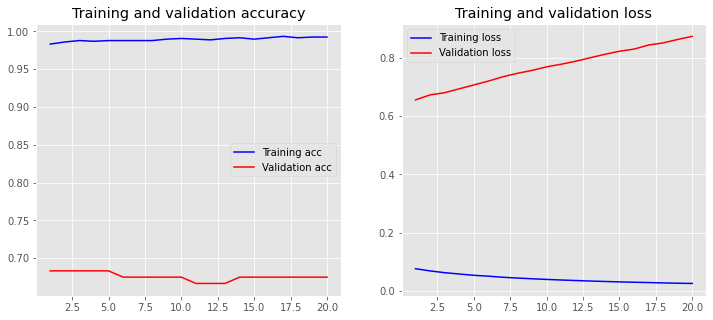

In [57]:
test_sample = "analytical skills"

history = embeddings_model.fit(padded_docs_train_tech, y_train_tech,
                    epochs=20,
                    verbose=False,
                    validation_data=(padded_docs_test_tech, y_test_tech),
                    batch_size=10)

loss, accuracy = embeddings_model.evaluate(padded_docs_train_tech, y_train_tech, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = embeddings_model.evaluate(padded_docs_test_tech, y_test_tech, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [58]:
#model.save('CNN_test_may18_10pct.model')

## Test model prediction

In [59]:
prediction_tech = embeddings_model.predict(padded_docs_test_tech)

In [60]:
df_tech= pd.DataFrame(X_test_tech)
df_tech["skill_tech"] = y_test_tech
df_tech["prediction"] = prediction_tech.round(0)
df_tech.shape

(120, 3)

In [61]:
df_tech.head(5)

combined_words  skill_tech  prediction
636                         sota ml           1         1.0
243   analysis system data analysis           1         1.0
1013         constraints experience           1         1.0
1113                           path           0         0.0
58              client stakeholders           0         1.0

In [62]:
actual_values = df_tech.skill_tech.values
predicted_values = df_tech.prediction.values.astype(int)

predicted_values

array([1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 0])

In [63]:
confusion = confusion_matrix(actual_values, predicted_values)
print(confusion)

[[44 20]
 [19 37]]


## Second version of model: 80 vs 20 split

In [101]:
X_train_tech, X_test_tech, y_train_tech, y_test_tech = train_test_split(df_chunk_tech["combined_words"], df_chunk_tech["Technical"], test_size=0.2, random_state=42)
X_train_tech.shape

vocab_size = 2000
encoded_docs_train_tech = [one_hot(d, vocab_size) for d in X_train_tech]

# pad documents to a max length of 4 words
max_length = 5
padded_docs_train_tech = pad_sequences(encoded_docs_train_tech, maxlen=max_length, padding='post')
print(padded_docs_train_tech)

encoded_docs_test_tech = [one_hot(d, vocab_size) for d in X_test_tech]

padded_docs_test_tech = pad_sequences(encoded_docs_test_tech, maxlen=max_length, padding='post')
#print(padded_docs_test)

# define the model
model = Sequential()
model.add(Embedding(vocab_size, 5, input_length=max_length))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())

# fit the model
model.fit(padded_docs_train_tech, y_train_tech, epochs=20, verbose=0)

model_tech_v2 = model.fit(padded_docs_train_tech, y_train_tech, epochs=25, 
                          validation_data = (padded_docs_test_tech, y_test_tech), verbose=2)

#model.save('CNN_test_may18_12pct.model')

prediction_tech_v2 = model.predict(padded_docs_test_tech)

df_tech_v2= pd.DataFrame(X_test_tech)
df_tech_v2["skill_tech"] = y_test_tech
df_tech_v2["prediction"] = prediction_tech_v2.round(0)
df_tech_v2.shape

actual_values_v2 = df_tech_v2.skill_tech.values
predicted_values_v2 = df_tech_v2.prediction.values.astype(int)

confusion_v2 = confusion_matrix(actual_values_v2, predicted_values_v2)
print(confusion_v2)

[[ 683 1037    0    0    0]
 [1881  393  178    0    0]
 [ 223   91 1630    0    0]
 ...
 [1471  770    0    0    0]
 [ 414   93    0    0    0]
 [ 393 1441  320    0    0]]
Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, 5, 5)              10000     
_________________________________________________________________
flatten_2 (Flatten)          (None, 25)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 26        
Total params: 10,026
Trainable params: 10,026
Non-trainable params: 0
_________________________________________________________________
None


/Users/catalinmates/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



Train on 956 samples, validate on 240 samples
Epoch 1/25
 - 0s - loss: 0.3854 - accuracy: 0.9111 - val_loss: 0.6183 - val_accuracy: 0.6625
Epoch 2/25
 - 0s - loss: 0.3696 - accuracy: 0.9142 - val_loss: 0.6168 - val_accuracy: 0.6667
Epoch 3/25
 - 0s - loss: 0.3546 - accuracy: 0.9184 - val_loss: 0.6157 - val_accuracy: 0.6667
Epoch 4/25
 - 0s - loss: 0.3401 - accuracy: 0.9257 - val_loss: 0.6154 - val_accuracy: 0.6667
Epoch 5/25
 - 0s - loss: 0.3266 - accuracy: 0.9278 - val_loss: 0.6151 - val_accuracy: 0.6667
Epoch 6/25
 - 0s - loss: 0.3136 - accuracy: 0.9299 - val_loss: 0.6148 - val_accuracy: 0.6708
Epoch 7/25
 - 0s - loss: 0.3013 - accuracy: 0.9310 - val_loss: 0.6154 - val_accuracy: 0.6667
Epoch 8/25
 - 0s - loss: 0.2897 - accuracy: 0.9341 - val_loss: 0.6158 - val_accuracy: 0.6625
Epoch 9/25
 - 0s - loss: 0.2783 - accuracy: 0.9393 - val_loss: 0.6170 - val_accuracy: 0.6625
Epoch 10/25
 - 0s - loss: 0.2680 - accuracy: 0.9467 - val_loss: 0.6191 - val_accuracy: 0.6625
Epoch 11/25
 - 0s - los

# Embeddings Layer parameter changes (Real Python website test)

In [193]:
embedding_dim = 50
maxlen = 5


embeddings_model_v1 = Sequential()
embeddings_model_v1.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
embeddings_model_v1.add(layers.Flatten())
embeddings_model_v1.add(layers.Dense(10, activation='relu'))
embeddings_model_v1.add(layers.Dense(1, activation='sigmoid'))
embeddings_model_v1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
embeddings_model_v1.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 5, 50)             100000    
_________________________________________________________________
flatten_5 (Flatten)          (None, 250)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                2510      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 11        
Total params: 102,521
Trainable params: 102,521
Non-trainable params: 0
_________________________________________________________________


In [194]:
history = embeddings_model_v1.fit(padded_docs_train_tech, y_train_tech,
                    epochs=20,
                    verbose=False,
                    validation_data=(padded_docs_test_tech, y_test_tech),
                    batch_size=10)

/Users/pavel/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.

/Users/pavel/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



train_teching Accuracy: 0.9944
Testing Accuracy:  0.5167


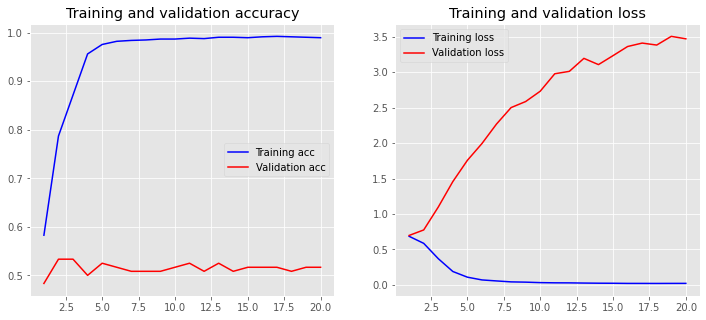

In [195]:
loss, accuracy = embeddings_model_v1.evaluate(padded_docs_train_tech, y_train_tech, verbose=False)
print("train_teching Accuracy: {:.4f}".format(accuracy))
loss, accuracy = embeddings_model_v1.evaluate(padded_docs_test_tech, y_test_tech, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

# Real Python website test version 2 model

In [196]:
embeddings_model_v2 = Sequential()
embeddings_model_v2.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
embeddings_model_v2.add(layers.GlobalMaxPool1D())
embeddings_model_v2.add(layers.Dense(10, activation='relu'))
embeddings_model_v2.add(layers.Dense(1, activation='sigmoid'))
embeddings_model_v2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
embeddings_model_v2.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 5, 50)             100000    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 50)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 11        
Total params: 100,521
Trainable params: 100,521
Non-trainable params: 0
_________________________________________________________________


In [197]:
history_v2 = embeddings_model_v2.fit(padded_docs_train_tech, y_train_tech,
                    epochs=20,
                    verbose=False,
                    validation_data=(padded_docs_test_tech, y_test_tech),
                    batch_size=10)

/Users/pavel/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.

/Users/pavel/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



train_teching Accuracy: 0.9944
Testing Accuracy:  0.5333


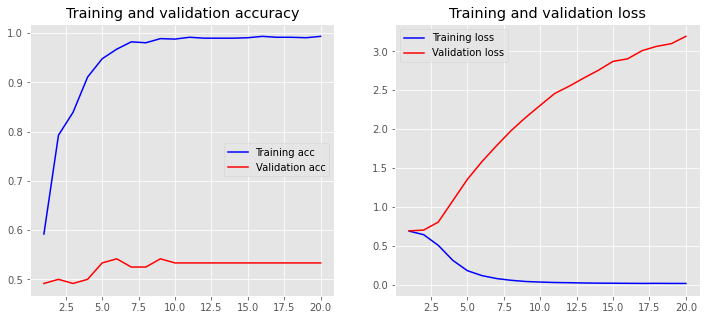

In [198]:
loss, accuracy = embeddings_model_v2.evaluate(padded_docs_train_tech, y_train_tech, verbose=False)
print("train_teching Accuracy: {:.4f}".format(accuracy))
loss, accuracy = embeddings_model_v2.evaluate(padded_docs_test_tech, y_test_tech, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_v2)

In [199]:
prediction_tech_v2 = embeddings_model_v2.predict(padded_docs_test_tech)

df_tech_v2= pd.DataFrame(X_test_tech)
df_tech_v2["skill_tech"] = y_test_tech
df_tech_v2["prediction"] = prediction_tech_v2.round(0)

actual_values_v2 = df_tech_v2.skill_tech.values
predicted_values_v2 = df_tech_v2.prediction.values.astype(int)

confusion_v2 = confusion_matrix(actual_values_v2, predicted_values_v2)
print(confusion_v2)

[[30 27]
 [29 34]]


## Real python test v3

In [223]:
embedding_dim = 5

embeddings_model_v3 = Sequential()
embeddings_model_v3.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
embeddings_model_v3.add(layers.Conv1D(128, 5, activation='relu'))
embeddings_model_v3.add(layers.GlobalMaxPooling1D())
embeddings_model_v3.add(layers.Dense(10, activation='relu'))
embeddings_model_v3.add(layers.Dense(1, activation='sigmoid'))
embeddings_model_v3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
embeddings_model_v3.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 5, 5)              10000     
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 1, 128)            3328      
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 128)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 11        
Total params: 14,629
Trainable params: 14,629
Non-trainable params: 0
_________________________________________________________________


In [224]:
history_v3 = embeddings_model_v3.fit(padded_docs_train_tech, y_train_tech,
                    epochs=20,
                    verbose=False,
                    validation_data=(padded_docs_test_tech, y_test_tech),
                    batch_size=10)

/Users/pavel/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.

/Users/pavel/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



train_teching Accuracy: 0.9935
Testing Accuracy:  0.5083


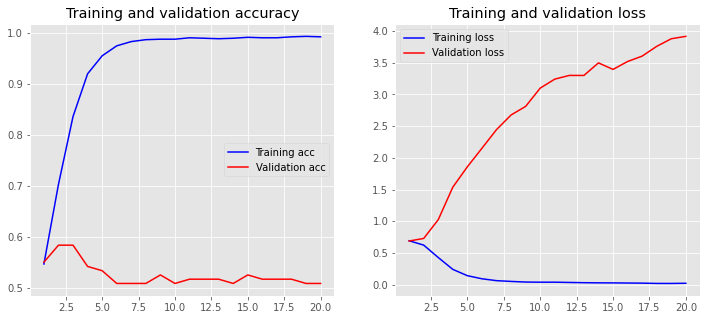

In [225]:
loss, accuracy = embeddings_model_v3.evaluate(padded_docs_train_tech, y_train_tech, verbose=False)
print("train_teching Accuracy: {:.4f}".format(accuracy))
loss, accuracy = embeddings_model_v3.evaluate(padded_docs_test_tech, y_test_tech, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_v3)

In [203]:
prediction_tech_v3 = embeddings_model_v3.predict(padded_docs_test_tech)

df_tech_v3= pd.DataFrame(X_test_tech)
df_tech_v3["skill_tech"] = y_test_tech
df_tech_v3["prediction"] = prediction_tech_v3.round(0)

actual_values_v3 = df_tech_v3.skill_tech.values
predicted_values_v3 = df_tech_v3.prediction.values.astype(int)

confusion_v3 = confusion_matrix(actual_values_v3, predicted_values_v3)
print(confusion_v3)

[[30 27]
 [30 33]]


# Hyperparameter optimization

In [15]:
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [383]:
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[3000, 6000, 10000], 
                  embedding_dim=[2, 5, 10],
                  maxlen=[5])

In [384]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV


# Main settings
epochs = 20
#embedding_dim = 2
maxlen = 5

model = KerasClassifier(build_fn=create_model,
                            epochs=epochs, batch_size=10,
                            verbose=False)


In [385]:
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                              cv=4, verbose=1, n_iter=5)

grid_result = grid.fit(padded_docs_train_tech, y_train_tech)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/catalinmates/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.

/Users/catalinmates/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.

/Users/catalinmates/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.

/Users/catalinmates/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserW

/Users/catalinmates/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.

/Users/catalinmates/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.

/Users/catalinmates/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.

/Users/catalinmates/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This

In [392]:
test_accuracy = grid.score(padded_docs_train_tech, y_train_tech)
print("Best Score: " + str(grid_result.best_score_) + '\n')

print("Optimal parameters: " + str(grid_result.best_params_) + '\n')

print("Test accuracy: " + str(test_accuracy) + '\n')

Best Score: 0.6338289976119995

Optimal parameters: {'vocab_size': 6000, 'num_filters': 128, 'maxlen': 5, 'kernel_size': 3, 'embedding_dim': 10}

Test accuracy: 0.9944238066673279



In [402]:
X_train_tech

943                          business groups
906                              data volume
451                                 priority
260                modeling concepts ability
244                   data mining algorithms
                        ...                 
1044                      data relationships
1095                          user interface
1130             sql data warehouse aix/unix
860                infrastructure automation
1126    intelligence enhance decision making
Name: combined_words, Length: 1076, dtype: object

In [403]:
padded_docs_train_tech

array([[ 405,  540,    0,    0,    0],
       [ 862,  937,    0,    0,    0],
       [ 645,    0,    0,    0,    0],
       ...,
       [ 814,  862,  902,   58, 1279],
       [1076,  666,    0,    0,    0],
       [ 489, 1054,  364,  809,    0]], dtype=int32)

/Users/catalinmates/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



Training Accuracy: 0.8959
Testing Accuracy:  0.7167


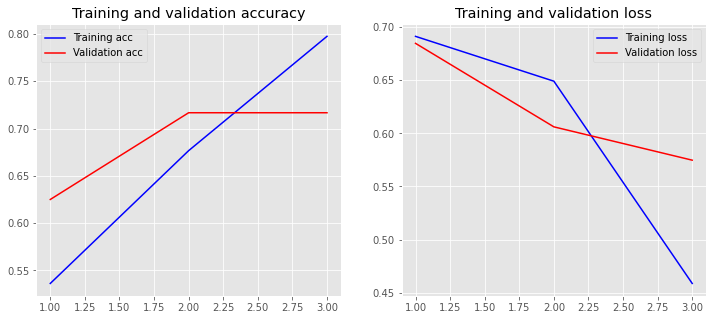

In [396]:
model = Sequential()
model.add(Embedding(6000, 10, input_length=5))
model.add(layers.Conv1D(128, 3, activation='relu'))


model.add(layers.GlobalMaxPool1D())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


history = model.fit(padded_docs_train_tech, y_train_tech,
                    epochs=3,
                    verbose=False,
                    validation_data=(padded_docs_test_tech, y_test_tech),
                    batch_size=10)

loss, accuracy = model.evaluate(padded_docs_train_tech, y_train_tech, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(padded_docs_test_tech, y_test_tech, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [404]:
padded_docs_train_tech

array([[ 405,  540,    0,    0,    0],
       [ 862,  937,    0,    0,    0],
       [ 645,    0,    0,    0,    0],
       ...,
       [ 814,  862,  902,   58, 1279],
       [1076,  666,    0,    0,    0],
       [ 489, 1054,  364,  809,    0]], dtype=int32)

In [397]:
prediction_tech = model.predict(padded_docs_test_tech)

df_tech= pd.DataFrame(X_test_tech)
df_tech["skill_tech"] = y_test_tech
df_tech["prediction"] = prediction_tech.round(0)

actual_values = df_tech.skill_tech.values
predicted_values = df_tech.prediction.values.astype(int)

confusion = confusion_matrix(actual_values, predicted_values)
print(confusion)

tru_neg = confusion[0][0]
tru_pos = confusion[1][1]

fal_neg = confusion[1][0]
fal_pos = confusion[0][1]

neg = confusion[0][0] + confusion[0][1]
pos = confusion[1][0] + confusion[1][1]

print('\n' + "Skills accuracy: " + str(tru_pos/(tru_pos+fal_pos)))

print('\n' + "Not a skill accuracy: " + str(tru_neg/(tru_neg+fal_neg)))

[[34 21]
 [13 52]]

Skills accuracy: 0.7123287671232876

Not a skill accuracy: 0.723404255319149


In [399]:
import pickle

In [400]:
pickle_out = open("skills_model", "wb")
pickle.dump(model, pickle_out)


In [374]:
y_train_tech

943     0
906     1
451     0
260     1
244     1
       ..
1044    1
1095    1
1130    1
860     1
1126    0
Name: Technical, Length: 1076, dtype: int64

### Test simple embedding layer

In [128]:
model = Sequential()
embedding_layer = Embedding(input_dim = 1435, output_dim = 3, input_length = 5)
model.add(embedding_layer)
model.compile('adam', 'mse')


In [129]:
model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_32 (Embedding)     (None, 5, 3)              4305      
Total params: 4,305
Trainable params: 4,305
Non-trainable params: 0
_________________________________________________________________


In [130]:
input_data

array([[1, 2, 0, 0, 0]])

In [131]:
model.predict(input_data)

array([[[ 0.02985022,  0.02790136, -0.01944227],
        [-0.0421368 , -0.00578408,  0.00203544],
        [ 0.04973266,  0.04455801, -0.00258354],
        [ 0.04973266,  0.04455801, -0.00258354],
        [ 0.04973266,  0.04455801, -0.00258354]]], dtype=float32)

In [132]:
embedding_layer.get_weights()

[array([[ 0.04973266,  0.04455801, -0.00258354],
        [ 0.02985022,  0.02790136, -0.01944227],
        [-0.0421368 , -0.00578408,  0.00203544],
        ...,
        [-0.02167587,  0.04762175, -0.03008216],
        [ 0.04547014,  0.00156039, -0.00518014],
        [-0.02908581, -0.02105124,  0.02322483]], dtype=float32)]

In [753]:
model.summary()

input_data

model.predict(input_data)

embedding_layer.get_weights()

Model: "sequential_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_80 (Embedding)     multiple                  62050     
_________________________________________________________________
conv1d_75 (Conv1D)           (None, None, 128)         19328     
_________________________________________________________________
global_max_pooling1d_50 (Glo (None, 128)               0         
_________________________________________________________________
dense_99 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_100 (Dense)            (None, 1)                 11        
Total params: 82,679
Trainable params: 82,679
Non-trainable params: 0
_________________________________________________________________


# ROC Curve

In [177]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

In [178]:
# Import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target

In [183]:
# Import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

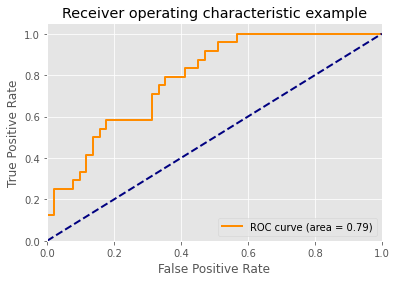

In [187]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Get Embedding Model weights

In [161]:
def extract_weights(name, model):
    """Extract weights from a neural network model"""
    
    # Extract weights
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    
    # Normalize
    weights = weights / np.linalg.norm(weights, axis = 1).reshape((-1, 1))
    return weights

In [162]:
for layer in model.layers:
    print(layer.name)

embedding_55
conv1d_50
global_max_pooling1d_29
dense_57
dense_58


In [214]:
weights_class = extract_weights('embedding_55', model)
#weights_class.shape

In [1145]:
weights_class

array([[ 0.34724513,  0.24465676, -0.2813888 , ..., -0.31450167,
         0.41430092,  0.31589067],
       [-0.45539248, -0.30313653, -0.01870805, ..., -0.14187881,
        -0.46743584, -0.3517018 ],
       [-0.10296201,  0.43788892, -0.442699  , ..., -0.00620052,
        -0.39364922,  0.14605151],
       ...,
       [ 0.23812467,  0.31897798,  0.2705243 , ..., -0.3820311 ,
         0.24999213, -0.02683131],
       [ 0.581272  , -0.21508579,  0.3648682 , ...,  0.22711293,
         0.13939694,  0.27200687],
       [-0.342524  , -0.27708903, -0.20056595, ...,  0.3573178 ,
         0.3931465 , -0.02295677]], dtype=float32)

In [165]:
model.get_layer('embedding_55').output

<tf.Tensor 'embedding_55/embedding_lookup/Identity_2:0' shape=(None, 5, 10) dtype=float32>

In [191]:
#weight_class = pd.DataFrame(weights_class)
#weight_class.head()

In [ ]:
# Possibly useful function to create a model from an intermediate layer

#from keras.models import Model

#model = ...  # include here your original model

#layer_name = 'my_layer'
#intermediate_layer_model = Model(inputs=model.input,
#                                 outputs=model.get_layer(layer_name).output)
#intermediate_output = intermediate_layer_model.predict(data)

In [1025]:
padded_docs_train_tech_df['weights_1'] = ''
padded_docs_train_tech_df['weights_2'] = ''
padded_docs_train_tech_df['weights_3'] = ''
padded_docs_train_tech_df['weights_4'] = ''
padded_docs_train_tech_df['weights_5'] = ''

padded_docs_test_tech_df['weights_1'] = ''
padded_docs_test_tech_df['weights_2'] = ''
padded_docs_test_tech_df['weights_3'] = ''
padded_docs_test_tech_df['weights_4'] = ''
padded_docs_test_tech_df['weights_5'] = ''


for i in range(1,6):
    for j in padded_docs_train_tech_df[i].index:
        d = padded_docs_train_tech_df[i][j]
    
        padded_docs_train_tech_df['weights_' + str(i)][j] = embedding_matrix[d]


for i in range(1,6):
    for j in padded_docs_test_tech_df[i].index:
        d = padded_docs_test_tech_df[i][j]
    
        padded_docs_test_tech_df['weights_' + str(i)][j] = embedding_matrix[d]

In [1026]:
padded_docs_test_tech_df.head()

1     2    3  4  5          combined_words  original_index  \
0   583   761    0  0  0       programming tests             636   
1    31  1393    0  0  0         solutions tools             243   
2  1386   379    0  0  0        ssis informatics            1013   
3  1295   227  756  0  0  azure stream analytics            1113   
4   763  1404    0  0  0          index requests              58   

                                             weights      tsne1      tsne2  \
0  [0.34724513, 0.24465676, -0.2813888, 0.0809517... -24.445557 -36.807659   
1  [-0.45539248, -0.30313653, -0.018708052, 0.071... -24.445572 -36.807816   
2  [-0.10296201, 0.43788892, -0.442699, -0.378454...   6.037718  14.983598   
3  [-0.3831826, -0.4364389, 0.117067575, -0.18764...  -3.903651 -33.539536   
4  [0.12855503, 0.19264516, 0.38986897, -0.373361...  -5.226231  15.426026   

                                           weights_1  \
0  [-0.0060270000249147415, 0.30867999792099, -0....   
1  [-0.3927119970321655, 0.8090289831161499, -0.0...   
2  [0.37615200877189636, -0.5500829815864563, -0....   
3  [-0.7099779844284058, 0.3615350127220154, -0.7...   
4  [1.0446490049362183, 0.6508179903030396, 0.974...   

                                           weights_2  \
0  [-0.5577210187911987, -1.0446070432662964, 0.2...   
1  [-0.3568440079689026, -0.12248600274324417, -0...   
2  [-0.3287299871444702, 0.3087019920349121, -0.0...   
3  [-0.25284600257873535, 0.8643540143966675, -0....   
4  [-0.4343099892139435, -0.4934130012989044, 0.2...   

                                           weights_3  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.4099220037460327, -0.03468399867415428, -0....   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                           weights_4  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                           weights_5  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                       weights_total  
0  [0.8559427, 0.8374901, -0.8403448, 0.18491161,...  
1  [1.4014276, 0.026108116, -0.121397465, 0.25839...  
2  [1.2727275, 0.6162389, -0.7068974, 0.57250136,...  
3  [0.9420285, -0.48612857, -1.0452223, -0.177144...  
4  [0.583353, -0.044257447, -0.49098304, -0.17383...

In [256]:
padded_docs_train_tech_df.tail()

1     2    3    4     5               combined_words  original_index  \
1071   862  1372    0    0     0           data relationships            1044   
1072  1170   750    0    0     0               user interface            1095   
1073   814   862  902   58  1279  sql data warehouse aix/unix            1130   
1074  1076   666    0    0     0    infrastructure automation             860   
1075   489  1054  364  809     0                         test               0   

                                                weights      tsne1      tsne2  \
1071  [-0.6226253, -0.082328886, 0.063336916, -0.102...  -1.321270  33.614994   
1072  [0.20064662, -0.112803705, -0.35383677, 0.3878... -16.854027 -35.917126   
1073  [0.3745246, 0.013506024, -0.631968, 0.05624232...  34.853138 -20.164761   
1074  [0.24270032, -0.20825183, -0.17341629, 0.38537...  26.057226 -28.257582   
1075  [-0.4096199, -0.23526223, 0.38835394, -0.06647...  38.975029  17.646755   

                                              weights_1  \
1071  [0.0559246, -0.39706394, -0.08733496, -0.08667...   
1072  [0.4555258, -0.23168644, -0.06089104, -0.26427...   
1073  [0.014869389, -0.20122792, -0.44756103, -0.115...   
1074  [-0.21957733, -0.07716131, 0.1299945, -0.77414...   
1075  [-0.04208371, -0.35215664, -0.06021032, -0.442...   

                                              weights_2  \
1071  [-0.010459631, -0.39644575, -0.26853234, 0.081...   
1072  [-0.22389762, -0.6108143, 0.1938676, -0.048893...   
1073  [0.0559246, -0.39706394, -0.08733496, -0.08667...   
1074  [-0.012366317, 0.48680294, 0.67447793, 0.24316...   
1075  [-0.18906051, -0.1732117, 0.054306787, 0.61197...   

                                              weights_3  \
1071  [0.34724513, 0.24465676, -0.2813888, 0.0809517...   
1072  [0.34724513, 0.24465676, -0.2813888, 0.0809517...   
1073  [-0.23502654, -0.613262, 0.11884557, -0.101154...   
1074  [0.34724513, 0.24465676, -0.2813888, 0.0809517...   
1075  [0.2136435, -0.24618542, -0.3747833, 0.0554868...   

                                              weights_4  \
1071  [0.34724513, 0.24465676, -0.2813888, 0.0809517...   
1072  [0.34724513, 0.24465676, -0.2813888, 0.0809517...   
1073  [0.50132406, 0.27375367, 0.19719765, 0.2348919...   
1074  [0.34724513, 0.24465676, -0.2813888, 0.0809517...   
1075  [0.20406559, -0.0041001565, 0.5230112, 0.34513...   

                                              weights_5  
1071  [0.34724513, 0.24465676, -0.2813888, 0.0809517...  
1072  [0.34724513, 0.24465676, -0.2813888, 0.0809517...  
1073  [0.27559656, 0.13481355, 0.2308044, 0.20681566...  
1074  [0.34724513, 0.24465676, -0.2813888, 0.0809517...  
1075  [0.34724513, 0.24465676, -0.2813888, 0.0809517...

In [257]:
padded_docs_test_tech_df.head()

1     2    3  4  5          combined_words  original_index  \
0   583   761    0  0  0       programming tests             636   
1    31  1393    0  0  0         solutions tools             243   
2  1386   379    0  0  0        ssis informatics            1013   
3  1295   227  756  0  0  azure stream analytics            1113   
4   763  1404    0  0  0          index requests              58   

                                             weights      tsne1      tsne2  \
0  [0.34724513, 0.24465676, -0.2813888, 0.0809517... -21.245932 -20.881655   
1  [-0.45539248, -0.30313653, -0.018708052, 0.071...  33.077934  14.266242   
2  [-0.10296201, 0.43788892, -0.442699, -0.378454...  13.037350 -31.015345   
3  [-0.3831826, -0.4364389, 0.117067575, -0.18764...  37.728867  21.857006   
4  [0.12855503, 0.19264516, 0.38986897, -0.373361...  -6.513994   8.926715   

                                           weights_1  \
0  [-0.046703763, -0.0886236, 0.1992542, -0.72001...   
1  [-0.016839975, -0.08318667, 0.53291804, 0.0793...   
2  [0.5938586, -0.6709161, 0.12499169, 0.06916017...   
3  [-0.25566623, -0.3330571, -0.45819414, -0.3972...   
4  [-0.37842968, -0.33369124, 0.17360727, -0.0176...   

                                           weights_2  \
0  [-0.13908885, 0.19214343, -0.1954326, 0.662067...   
1  [0.37653226, -0.62467545, 0.18985087, -0.06376...   
2  [-0.36286643, 0.5531847, 0.012277258, 0.260485...   
3  [0.51697016, -0.100512, -0.06277281, 0.1698359...   
4  [-0.07995271, -0.44453642, 0.17957604, -0.3990...   

                                           weights_3  \
0  [0.34724513, 0.24465676, -0.2813888, 0.0809517...   
1  [0.34724513, 0.24465676, -0.2813888, 0.0809517...   
2  [0.34724513, 0.24465676, -0.2813888, 0.0809517...   
3  [-0.013765614, -0.5418729, 0.03852221, -0.1116...   
4  [0.34724513, 0.24465676, -0.2813888, 0.0809517...   

                                           weights_4  \
0  [0.34724513, 0.24465676, -0.2813888, 0.0809517...   
1  [0.34724513, 0.24465676, -0.2813888, 0.0809517...   
2  [0.34724513, 0.24465676, -0.2813888, 0.0809517...   
3  [0.34724513, 0.24465676, -0.2813888, 0.0809517...   
4  [0.34724513, 0.24465676, -0.2813888, 0.0809517...   

                                           weights_5  
0  [0.34724513, 0.24465676, -0.2813888, 0.0809517...  
1  [0.34724513, 0.24465676, -0.2813888, 0.0809517...  
2  [0.34724513, 0.24465676, -0.2813888, 0.0809517...  
3  [0.34724513, 0.24465676, -0.2813888, 0.0809517...  
4  [0.34724513, 0.24465676, -0.2813888, 0.0809517...

In [1027]:
padded_docs_train_tech_df['weights_total'] = padded_docs_train_tech_df['weights_1'] + padded_docs_train_tech_df['weights_2'] + padded_docs_train_tech_df['weights_3'] + padded_docs_train_tech_df['weights_4'] + padded_docs_train_tech_df['weights_5'] 


In [1028]:
padded_docs_test_tech_df['weights_total'] = padded_docs_test_tech_df['weights_1'] + padded_docs_test_tech_df['weights_2'] + padded_docs_test_tech_df['weights_3'] + padded_docs_test_tech_df['weights_4'] + padded_docs_test_tech_df['weights_5'] 

In [1033]:
padded_docs_train_tech_df

1     2    3    4     5               combined_words  original_index  \
0      405   540    0    0     0              business groups             943   
1      862   937    0    0     0                  data volume             906   
2      645     0    0    0     0                     priority             451   
3      622    79  568    0     0    modeling concepts ability             260   
4      862   284  237    0     0       data mining algorithms             244   
...    ...   ...  ...  ...   ...                          ...             ...   
1071   862  1372    0    0     0           data relationships            1044   
1072  1170   750    0    0     0               user interface            1095   
1073   814   862  902   58  1279  sql data warehouse aix/unix            1130   
1074  1076   666    0    0     0    infrastructure automation             860   
1075   489  1054  364  809     0                         test               0   

                                                weights      tsne1      tsne2  \
0     [0.34724513, 0.24465676, -0.2813888, 0.0809517... -24.445557 -36.807659   
1     [-0.45539248, -0.30313653, -0.018708052, 0.071... -24.445572 -36.807816   
2     [-0.10296201, 0.43788892, -0.442699, -0.378454...   6.037718  14.983598   
3     [-0.3831826, -0.4364389, 0.117067575, -0.18764...  -3.903651 -33.539536   
4     [0.12855503, 0.19264516, 0.38986897, -0.373361...  -5.226231  15.426026   
...                                                 ...        ...        ...   
1071  [-0.6226253, -0.082328886, 0.063336916, -0.102...  27.398954   6.485721   
1072  [0.20064662, -0.112803705, -0.35383677, 0.3878...  13.642647  -2.353324   
1073  [0.3745246, 0.013506024, -0.631968, 0.05624232...  -3.544371 -28.560059   
1074  [0.24270032, -0.20825183, -0.17341629, 0.38537...  -8.959738 -24.963554   
1075  [-0.4096199, -0.23526223, 0.38835394, -0.06647... -19.583151 -49.874035   

                                              weights_1  \
0     [0.6107370257377625, -0.250355988740921, -0.68...   
1     [-0.09453099966049194, 0.09909799695014954, 0....   
2     [0.3805469870567322, 0.4768170118331909, -0.11...   
3     [-0.5185239911079407, -0.03133700042963028, 0....   
4     [-0.09453099966049194, 0.09909799695014954, 0....   
...                                                 ...   
1071  [-0.09453099966049194, 0.09909799695014954, 0....   
1072  [-0.05633699893951416, -0.7085059881210327, 0....   
1073  [0.13907599449157715, 0.07874500006437302, 1.4...   
1074  [0.16711799800395966, -0.9958029985427856, 0.1...   
1075  [0.19626200199127197, 0.6418840289115906, -0.2...   

                                              weights_2  \
0     [0.018066000193357468, -0.08677099645137787, 0...   
1     [-0.20633700489997864, -0.8136910200119019, -0...   
2     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3     [0.37288400530815125, 1.0073620080947876, 0.20...   
4     [0.46365100145339966, -0.22769199311733246, -0...   
...                                                 ...   
1071  [-0.4997110068798065, -0.4806619882583618, 0.1...   
1072  [1.1309609413146973, -0.20549699664115906, -0....   
1073  [-0.09453099966049194, 0.09909799695014954, 0....   
1074  [-0.16276699304580688, -0.26123499870300293, -...   
1075  [-0.04240899905562401, -0.27212199568748474, 0...   

                                              weights_3  \
0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3     [0.8440020084381104, -0.3628840148448944, 0.03...   
4     [0.14338800311088562, 1.1167399883270264, 0.87...   
...                                                 ...   
1071  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1072  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1073  [-0.1503559947013855, 0.8746880292892456, 0.25...   
1074  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

In [1060]:
#weights_total = np.empty([1, 50])

for i in padded_docs_train_tech_df['weights_total'].index:
    temp = array(padded_docs_train_tech_df['weights_total'][i])
    reshape = temp.reshape(temp.shape[0],1)
    transpose = reshape.transpose()
    weights_total = transpose
    
    if weights_total.shape[0] != 0:
        weights_total = np.append(weights_total, transpose, axis = 0)
        
weights_total

array([[-1.01738196,  0.68910903, -1.01903798, -0.76106399, -1.04401299,
         0.21741699, -1.27066298, -1.21554201, -0.483001  ,  1.124461  ,
         0.49393597,  0.03622003, -0.45631798, -0.53420004, -0.18742099,
        -0.72674001,  0.41458903,  0.44146093,  1.135014  ,  1.00925201,
         0.86473498,  0.73249397, -0.60714599, -0.10721501, -0.38577698,
         0.39638099,  0.77568404, -0.38145398,  0.13255201,  0.731727  ,
        -0.34389901, -1.37559104,  1.52462095,  0.602017  , -0.492235  ,
         1.01337799,  0.503868  ,  1.01752299, -0.34774601, -0.09811004,
        -0.794135  , -0.00262398, -0.282645  ,  0.96543502, -0.52158402,
        -0.786763  ,  0.17896501,  0.61102998, -1.019982  ,  0.97874697],
       [-1.01738196,  0.68910903, -1.01903798, -0.76106399, -1.04401299,
         0.21741699, -1.27066298, -1.21554201, -0.483001  ,  1.124461  ,
         0.49393597,  0.03622003, -0.45631798, -0.53420004, -0.18742099,
        -0.72674001,  0.41458903,  0.44146093,  1.

In [1076]:
#weights_total = np.empty([1, 50])
for i in padded_docs_train_tech_df['weights_total'].index:
    temp = array(padded_docs_train_tech_df['weights_total'][i])
    reshape = temp.reshape(temp.shape[0],1)
    transpose = reshape.transpose()
    
    if i == 0:
        weights_total = transpose
    else:
        weights_total = np.append(weights_total, transpose, axis = 0)
    
weights_total

array([[ 0.62880303, -0.33712699, -0.38858703, ...,  0.540041  ,
         0.27028599,  0.36884999],
       [-0.300868  , -0.71459302, -0.50283901, ...,  0.250923  ,
        -0.042055  , -0.086981  ],
       [ 0.38054699,  0.47681701, -0.117596  , ...,  0.151278  ,
         0.15773299, -0.004776  ],
       ...,
       [ 1.52342501,  0.98351402,  0.6088701 , ...,  0.958993  ,
         1.81390902,  0.98473002],
       [ 0.004351  , -1.257038  , -0.051306  , ...,  1.46378201,
        -0.63473299, -0.02072901],
       [-1.01738196,  0.68910903, -1.01903798, ...,  0.61102998,
        -1.019982  ,  0.97874697]])

In [1078]:
weights_total.shape

(1076, 50)

# Visualization

In [1079]:
from sklearn.manifold import TSNE
#from umap import UMAP

In [1080]:
def reduce_dim(weights, components = 3, method = 'tsne'):
    """Reduce dimensions of embeddings"""
    if method == 'tsne':
        return TSNE(components, metric = 'cosine').fit_transform(weights)
    elif method == 'umap':
        # Might want to try different parameters for UMAP
        return UMAP(n_components=components, metric = 'cosine', 
                    init = 'random', n_neighbors = 5).fit_transform(weights)

In [1081]:
# Reduce dimensions from 10 down to 2 using TSNE method
combined_words_r = reduce_dim(weights_total, components = 2, method = 'tsne')
combined_words_r.shape

(1076, 2)

In [1082]:
combined_words_r[0]

array([-17.543026, -10.207508], dtype=float32)

In [1083]:
combined_words_r[0:5]

array([[-17.543026 , -10.207508 ],
       [  3.3232975,  12.360606 ],
       [-32.35527  ,  10.473757 ],
       [ -1.6494794,  31.648726 ],
       [ -9.393518 ,   6.998106 ]], dtype=float32)

In [1084]:
padded_docs_train_tech_df['tsne1'] = 0.0
padded_docs_train_tech_df['tsne2'] = 0.0
padded_docs_test_tech_df['tsne1'] = 0.0
padded_docs_test_tech_df['tsne2'] = 0.0

i=0
for d, e in combined_words_r:
    padded_docs_train_tech_df['tsne1'][i] = d
    padded_docs_train_tech_df['tsne2'][i] = e
    i+=1
    
i=0
for d, e in combined_words_r:
    padded_docs_test_tech_df['tsne1'][i] = d
    padded_docs_test_tech_df['tsne2'][i] = e
    i+=1
    
padded_docs_train_tech_df.head()

1    2    3  4  5             combined_words  original_index  \
0  405  540    0  0  0            business groups             943   
1  862  937    0  0  0                data volume             906   
2  645    0    0  0  0                   priority             451   
3  622   79  568  0  0  modeling concepts ability             260   
4  862  284  237  0  0     data mining algorithms             244   

                                             weights      tsne1      tsne2  \
0  [0.34724513, 0.24465676, -0.2813888, 0.0809517... -17.543026 -10.207508   
1  [-0.45539248, -0.30313653, -0.018708052, 0.071...   3.323298  12.360606   
2  [-0.10296201, 0.43788892, -0.442699, -0.378454... -32.355270  10.473757   
3  [-0.3831826, -0.4364389, 0.117067575, -0.18764...  -1.649479  31.648726   
4  [0.12855503, 0.19264516, 0.38986897, -0.373361...  -9.393518   6.998106   

                                           weights_1  \
0  [0.6107370257377625, -0.250355988740921, -0.68...   
1  [-0.09453099966049194, 0.09909799695014954, 0....   
2  [0.3805469870567322, 0.4768170118331909, -0.11...   
3  [-0.5185239911079407, -0.03133700042963028, 0....   
4  [-0.09453099966049194, 0.09909799695014954, 0....   

                                           weights_2  \
0  [0.018066000193357468, -0.08677099645137787, 0...   
1  [-0.20633700489997864, -0.8136910200119019, -0...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.37288400530815125, 1.0073620080947876, 0.20...   
4  [0.46365100145339966, -0.22769199311733246, -0...   

                                           weights_3  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.8440020084381104, -0.3628840148448944, 0.03...   
4  [0.14338800311088562, 1.1167399883270264, 0.87...   

                                           weights_4  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                           weights_5  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                       weights_total  skills  
0  [0.6288030259311199, -0.3371269851922989, -0.3...     1.0  
1  [-0.3008680045604706, -0.7145930230617523, -0....     1.0  
2  [0.3805469870567322, 0.4768170118331909, -0.11...     1.0  
3  [0.6983620226383209, 0.6131409928202629, 0.654...     0.0  
4  [0.5125080049037933, 0.9881459921598434, 0.890...     1.0

In [1085]:
padded_docs_train_tech_df["skills"] = y_train_tech
padded_docs_train_tech_df

1     2    3    4     5               combined_words  original_index  \
0      405   540    0    0     0              business groups             943   
1      862   937    0    0     0                  data volume             906   
2      645     0    0    0     0                     priority             451   
3      622    79  568    0     0    modeling concepts ability             260   
4      862   284  237    0     0       data mining algorithms             244   
...    ...   ...  ...  ...   ...                          ...             ...   
1071   862  1372    0    0     0           data relationships            1044   
1072  1170   750    0    0     0               user interface            1095   
1073   814   862  902   58  1279  sql data warehouse aix/unix            1130   
1074  1076   666    0    0     0    infrastructure automation             860   
1075   489  1054  364  809     0                         test               0   

                                                weights      tsne1      tsne2  \
0     [0.34724513, 0.24465676, -0.2813888, 0.0809517... -17.543026 -10.207508   
1     [-0.45539248, -0.30313653, -0.018708052, 0.071...   3.323298  12.360606   
2     [-0.10296201, 0.43788892, -0.442699, -0.378454... -32.355270  10.473757   
3     [-0.3831826, -0.4364389, 0.117067575, -0.18764...  -1.649479  31.648726   
4     [0.12855503, 0.19264516, 0.38986897, -0.373361...  -9.393518   6.998106   
...                                                 ...        ...        ...   
1071  [-0.6226253, -0.082328886, 0.063336916, -0.102...   3.206942   9.361658   
1072  [0.20064662, -0.112803705, -0.35383677, 0.3878...   9.532139  28.455946   
1073  [0.3745246, 0.013506024, -0.631968, 0.05624232... -16.949490  -1.241004   
1074  [0.24270032, -0.20825183, -0.17341629, 0.38537... -33.554214  18.290277   
1075  [-0.4096199, -0.23526223, 0.38835394, -0.06647...  25.372734   7.668595   

                                              weights_1  \
0     [0.6107370257377625, -0.250355988740921, -0.68...   
1     [-0.09453099966049194, 0.09909799695014954, 0....   
2     [0.3805469870567322, 0.4768170118331909, -0.11...   
3     [-0.5185239911079407, -0.03133700042963028, 0....   
4     [-0.09453099966049194, 0.09909799695014954, 0....   
...                                                 ...   
1071  [-0.09453099966049194, 0.09909799695014954, 0....   
1072  [-0.05633699893951416, -0.7085059881210327, 0....   
1073  [0.13907599449157715, 0.07874500006437302, 1.4...   
1074  [0.16711799800395966, -0.9958029985427856, 0.1...   
1075  [0.19626200199127197, 0.6418840289115906, -0.2...   

                                              weights_2  \
0     [0.018066000193357468, -0.08677099645137787, 0...   
1     [-0.20633700489997864, -0.8136910200119019, -0...   
2     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3     [0.37288400530815125, 1.0073620080947876, 0.20...   
4     [0.46365100145339966, -0.22769199311733246, -0...   
...                                                 ...   
1071  [-0.4997110068798065, -0.4806619882583618, 0.1...   
1072  [1.1309609413146973, -0.20549699664115906, -0....   
1073  [-0.09453099966049194, 0.09909799695014954, 0....   
1074  [-0.16276699304580688, -0.26123499870300293, -...   
1075  [-0.04240899905562401, -0.27212199568748474, 0...   

                                              weights_3  \
0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3     [0.8440020084381104, -0.3628840148448944, 0.03...   
4     [0.14338800311088562, 1.1167399883270264, 0.87...   
...                                                 ...   
1071  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1072  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1073  [-0.1503559947013855, 0.8746880292892456, 0.25...   
1074  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

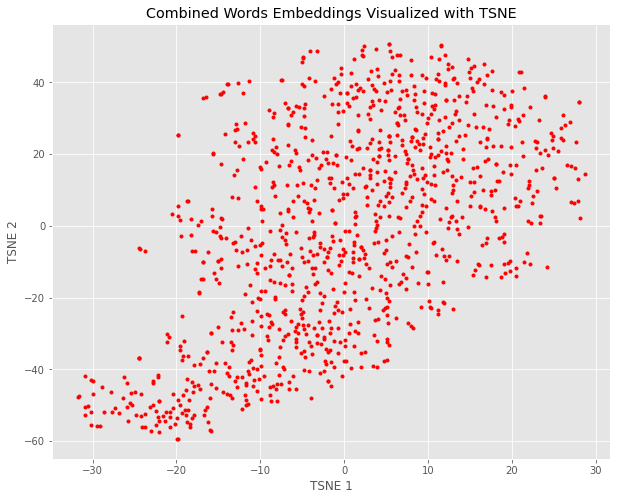

In [363]:
InteractiveShell.ast_node_interactivity = 'last'

plt.figure(figsize = (10, 8))
plt.plot(combined_words_r[:, 0], combined_words_r[:, 1], 'r.')
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('Combined Words Embeddings Visualized with TSNE');

In [1125]:
import random

padded_docs_train_tech_df_rand = padded_docs_train_tech_df.iloc[
    random.sample(range(0, len(padded_docs_train_tech_df.index)-1), 1000)]
padded_docs_train_tech_df_rand = padded_docs_train_tech_df_rand.reset_index().drop(columns = ('index'))
padded_docs_train_tech_df_rand.head()

1     2     3     4    5                            combined_words  \
0  1413  1180    83  1021  993  experience disney streaming services dss   
1   862   864  1096     0    0                     data curation efforts   
2   377   700   622     0    0           analysis visualization modeling   
3   509     0     0     0    0                                    latter   
4     6   252     0     0    0                     customer expectations   

   original_index                                            weights  \
0             863  [0.594177, 0.057976272, -0.32167014, -0.171043...   
1             653  [0.258305, 0.55500007, -0.4374546, -0.01142751...   
2             961  [0.20175675, -0.5162847, 0.34260434, -0.045162...   
3             826  [-0.365175, 0.11195777, 0.26017216, -0.4810334...   
4             595  [-0.16462117, 0.25513366, 0.1856549, 0.0710831...   

       tsne1      tsne2                                          weights_1  \
0   0.471984 -13.150482  [0.6950539946556091, 0.97604900598526, -1.1064...   
1  -5.111766  38.214329  [-0.09453099966049194, 0.09909799695014954, 0....   
2  -5.247015 -16.562559  [0.3509890139102936, 0.06450700014829636, -0.1...   
3  21.085354  17.235098  [0.3288629949092865, 0.8656219840049744, 0.734...   
4   1.348683 -11.839464  [-0.19936299324035645, 0.835174024105072, 0.47...   

                                           weights_2  \
0  [-0.23093999922275543, 0.010503999888896942, 0...   
1  [-0.021983999758958817, 0.9677109718322754, 0....   
2  [-0.4791310131549835, -0.47237899899482727, 0....   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.6157860159873962, 0.3750289976596832, -0.33...   

                                           weights_3  \
0  [-0.330128014087677, -0.548222005367279, 0.834...   
1  [0.12289199978113174, 0.23541200160980225, 0.2...   
2  [-0.5185239911079407, -0.03133700042963028, 0....   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                           weights_4  \
0  [0.19608399271965027, -0.2764430046081543, -0....   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                           weights_5  \
0  [-0.10892099887132645, 0.08080200105905533, -0...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                       weights_total  skills  
0  [0.22114897519350052, 0.24268999695777893, -0....     1.0  
1  [0.0063770003616809845, 1.3022209703922272, 0....     1.0  
2  [-0.6466659903526306, -0.4392089992761612, 0.7...     NaN  
3  [0.3288629949092865, 0.8656219840049744, 0.734...     1.0  
4  [0.4164230227470398, 1.2102030217647552, 0.140...     1.0

In [1126]:
padded_docs_train_tech_df_rand.weights_total

0      [0.22114897519350052, 0.24268999695777893, -0....
1      [0.0063770003616809845, 1.3022209703922272, 0....
2      [-0.6466659903526306, -0.4392089992761612, 0.7...
3      [0.3288629949092865, 0.8656219840049744, 0.734...
4      [0.4164230227470398, 1.2102030217647552, 0.140...
                             ...                        
995    [-0.01791200041770935, 0.3166719898581505, -0....
996    [-0.1716570109128952, -0.1547050029039383, -0....
997    [-0.39140699803829193, 0.6186670064926147, -0....
998    [-0.09835198521614075, -0.8093469813466072, 0....
999    [-0.48734299669013126, 0.990136981010437, -0.7...
Name: weights_total, Length: 1000, dtype: object

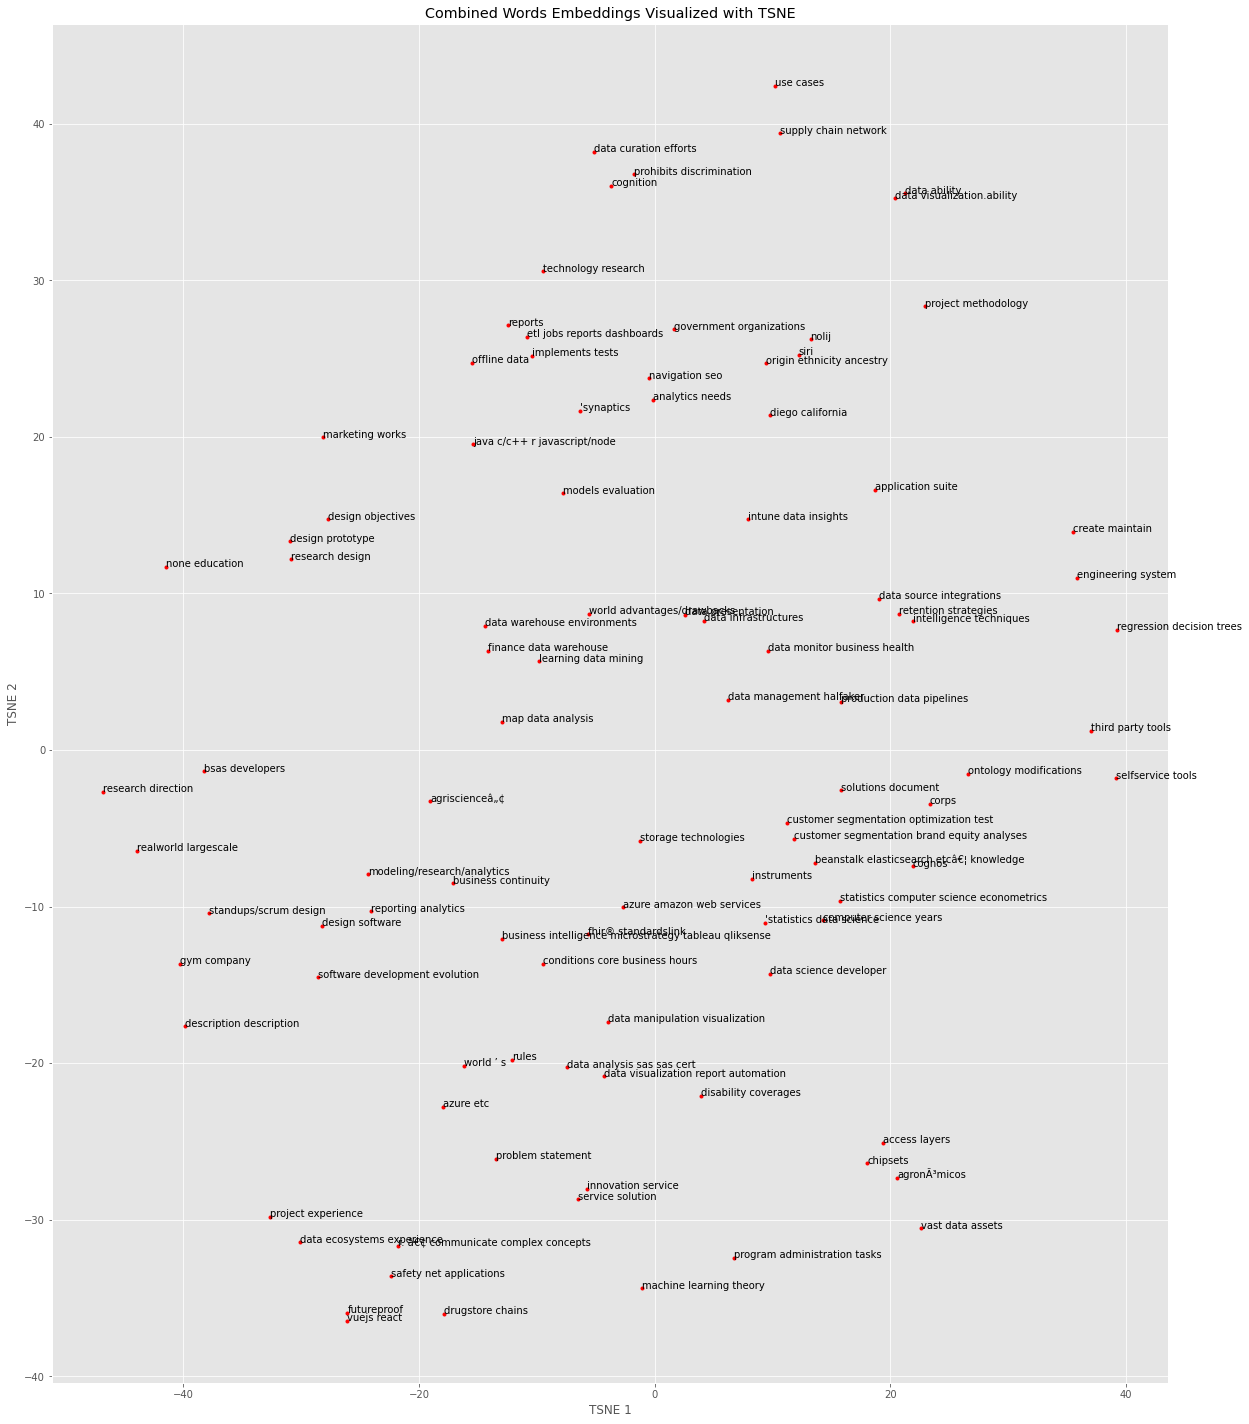

In [1087]:
InteractiveShell.ast_node_interactivity = 'last'

plt.figure(figsize = (20, 25))
plt.plot(padded_docs_train_tech_df_rand['tsne1'], padded_docs_train_tech_df_rand['tsne2'], 'r.')
#plt.plot(padded_docs_train_tech_df_rand['tsne1'], 'b.', padded_docs_train_tech_df_rand['tsne2'], 'r.')

for i, txt in enumerate(padded_docs_train_tech_df_rand['combined_words']):
    plt.annotate(txt, (padded_docs_train_tech_df_rand['tsne1'][i], padded_docs_train_tech_df_rand['tsne2'][i]))
    
    
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('Combined Words Embeddings Visualized with TSNE');


#plt.savefig('Embeddings_sample.png')

#fig = px.bar(gender_df, y='User Count', x = 'Gender', hover_data=['Gender', 'User Count'], color='Gender')

In [1088]:
import plotly.graph_objects as go

#title = 'USA: Job counts by week'
x = padded_docs_train_tech_df_rand['tsne1']


y_ds = padded_docs_train_tech_df_rand['tsne2']

color = padded_docs_train_tech_df_rand['skills']

fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=y_ds, mode='markers',
            marker=dict(color=color))
             )

#fig.update_traces(hoverinfo='text+name', mode='lines+markers')
fig.update_layout(showlegend = True)

fig.show()

# Get embeddings for combined words

## Word2Vec

In [424]:
from tensorflow.keras.utils import get_file

try:
    path = get_file('GoogleNews-vectors-negative300.bin.gz', origin='https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz')
except:
    print('Error downloading')
    raise
    
print(path)

1647050752/1647046227 [==============================] - 3526s 2us/step
/Users/catalinmates/.keras/datasets/GoogleNews-vectors-negative300.bin.gz


In [425]:
import gensim

# Not that the path below refers to a location on my hard drive.
# You should download GoogleNews Vectors (see suggested software above)
model = gensim.models.KeyedVectors.load_word2vec_format(path, binary=True)

In [431]:
w = model['science']
w

array([ 0.0090332 ,  0.12158203,  0.3984375 ,  0.21386719, -0.01672363,
        0.06396484,  0.3125    , -0.23535156, -0.10009766, -0.09326172,
        0.20507812, -0.03222656, -0.21191406,  0.00958252, -0.27734375,
        0.09619141, -0.1875    , -0.04052734,  0.2265625 , -0.23632812,
       -0.04858398,  0.03295898, -0.08056641,  0.12255859,  0.05859375,
       -0.09130859, -0.02685547,  0.02587891, -0.11376953, -0.21972656,
       -0.0378418 , -0.15722656, -0.05981445, -0.01635742,  0.11425781,
       -0.15234375, -0.01086426,  0.29296875,  0.22265625, -0.00245667,
       -0.16308594, -0.11669922, -0.20800781,  0.31835938, -0.08740234,
        0.13378906,  0.15429688,  0.11816406, -0.07470703,  0.09326172,
       -0.32421875,  0.01239014, -0.07226562, -0.10986328, -0.07177734,
        0.16113281,  0.05541992, -0.3984375 , -0.04980469, -0.25195312,
       -0.05249023, -0.05786133,  0.16699219, -0.26953125, -0.04394531,
       -0.14257812,  0.03662109,  0.34765625, -0.10888672, -0.12

In [444]:
#model.most_similar(positive=['data', 'science'], negative=['machine'])

model.most_similar(positive=['girl'])

[('boy', 0.8543272018432617),
 ('teenage_girl', 0.7927976250648499),
 ('woman', 0.7494640946388245),
 ('teenager', 0.7172499299049377),
 ('schoolgirl', 0.7075953483581543),
 ('teenaged_girl', 0.6650916337966919),
 ('daughter', 0.6489864587783813),
 ('mother', 0.6478164196014404),
 ('toddler', 0.6473966836929321),
 ('girls', 0.6154742240905762)]

In [446]:
glove_model = model

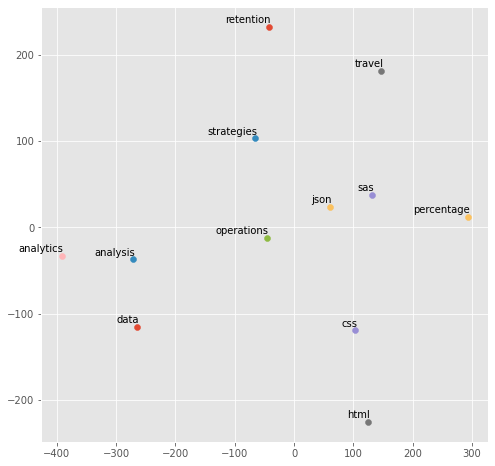

In [451]:
vocab = ["data", "analysis", "sas", "travel",  "percentage", "operations", "analytics", "retention", "strategies","css", "html", "json" ]
#vocab = ["data analysis", "sas", "sas cert", "travel percentage", "operations analytics", "retention strategies", "css html json" ]

def tsne_plot(model):
    labels = []
    wordvecs = []

    for word in vocab:
        wordvecs.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=3, n_components=2, init='pca', random_state=42)
    coordinates = tsne_model.fit_transform(wordvecs)

    x = []
    y = []
    for value in coordinates:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(8,8)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(2, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

tsne_plot(glove_model)

## GLOVE

In [51]:
#import numpy as np
from scipy import spatial
#import matplotlib.pyplot as plt
#from sklearn.manifold import TSNE

In [52]:
chunk_array = np.array(df_chunk_tech.combined_words)
#for chunk in :
 #   chunk_array.append(np.array(chunk))

chunk_array[:5]

NameError: name 'df_chunk_tech' is not defined

In [513]:
#with open('listfile.txt', 'w') as filehandle:
 #   filehandle.writelines("%s\n" % place for place in chunk_array)

In [53]:
embeddings_dict = {}
with open("vectors_fullnounslist.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [54]:
def find_closest_embeddings(embedding):
    return sorted(embeddings_dict.keys(), key=lambda word: spatial.distance.euclidean(embeddings_dict[word], embedding))


In [55]:
embeddings_dict

{'data': array([-4.311170e-01,  8.503100e-01,  7.764240e-01, -1.630494e+00,
         6.061140e-01, -3.125200e-02,  4.649410e-01, -9.074050e-01,
        -8.983600e-02,  1.408361e+00,  2.548150e-01,  1.940574e+00,
        -1.786700e-01, -9.011890e-01, -1.198160e+00, -1.748506e+00,
        -6.840420e-01,  7.277170e-01,  2.422330e-01, -2.108000e-03,
         8.311000e-02, -3.976280e-01, -7.077590e-01, -2.287019e+00,
        -2.048522e+00,  4.335150e-01,  1.575200e-02, -1.039990e-01,
        -1.289387e+00,  7.282060e-01, -9.679090e-01,  3.892280e-01,
         3.771840e-01,  1.275560e-01, -2.171689e+00, -2.477920e-01,
        -2.564190e-01,  3.931620e-01, -7.136450e-01,  1.270302e+00,
         1.706661e+00,  5.857590e-01, -1.972320e-01,  1.653624e+00,
        -8.260270e-01, -7.454500e-01, -1.523422e+00, -9.424750e-01,
         8.264400e-01,  1.483342e+00], dtype=float32),
 'experience': array([ 0.002261,  0.301262,  0.156417, -0.542805,  1.222397, -0.357455,
         0.589258,  0.757287,  0.

In [56]:
test = find_closest_embeddings(embeddings_dict["python"])[:20]
test

['python',
 'r',
 'languages',
 'java',
 'programming',
 'scala',
 'c/c++',
 'proficiency',
 'matlab',
 'proficient',
 'julia',
 'sql',
 'c++',
 'language',
 'scripting',
 'and/or',
 'pyspark',
 'spss',
 'coding',
 'sas']

In [59]:
for word in test:
    print('Similarity score with ' + str(word) + ' :', cos_sim(embeddings_dict['python'],embeddings_dict[word]))

Similarity score with python : 1.0
Similarity score with r : 0.9075751
Similarity score with languages : 0.89129275
Similarity score with java : 0.81163985
Similarity score with programming : 0.80412394
Similarity score with scala : 0.7989819
Similarity score with c/c++ : 0.7649114
Similarity score with proficiency : 0.7550609
Similarity score with matlab : 0.7470358
Similarity score with proficient : 0.731463
Similarity score with julia : 0.7471317
Similarity score with sql : 0.74414593
Similarity score with c++ : 0.7311373
Similarity score with language : 0.7200384
Similarity score with scripting : 0.71957815
Similarity score with and/or : 0.7028174
Similarity score with pyspark : 0.70714206
Similarity score with spss : 0.6770498
Similarity score with coding : 0.69397795
Similarity score with sas : 0.67706114


# Glove based on combined_chunks

In [283]:
embeddings_dict = {}
with open("vectors_chunks.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [287]:
find_closest_embeddings(embeddings_dict["python_scala"])[:20]

['python_scala',
 'python_ability',
 'scale_data_analysis',
 'matlab',
 'scipy',
 'spark_kafka',
 'd_team',
 'python_java',
 'd_projects',
 'linux_shell',
 'mysql',
 'tool',
 'graph_databases',
 'python_r_etc',
 'java_development_experience',
 'engineering_experience',
 'data_visualization_experience',
 'sql_knowledge',
 'query_language',
 'r_ability']

In [626]:
tsne = TSNE(n_components=2, random_state=0)

words =  list(embeddings_dict.keys())
vectors = [embeddings_dict[word] for word in words]

In [627]:
Y = tsne.fit_transform(vectors[:100])
Y[:5]

#plt.show()


array([[-3.313892 , -4.380509 ],
       [ 2.1619403, -4.6070867],
       [-1.5474153, -4.468031 ],
       [-6.8862505, -1.2328832],
       [-4.99378  , -2.3374496]], dtype=float32)

In [976]:
all_words = embeddings_dict.keys()
all_words

dict_keys(['data', 'experience', 'business', 'science', 'team', 'analytics', 'skills', 'work', 'machine', 'solutions', 'ability', 'analysis', 'years', 'development', 'information', '’', 'engineering', 'models', 'research', 'knowledge', 'tools', 'systems', 'management', 'opportunity', 'product', 'job', 'technology', 'status', 'learning', 'position', 'design', 'teams', 'requirements', 'qualifications', 'computer', 'software', 'company', 'environment', 'role', 'health', 'insights', 'techniques', 'python', 'problems', 'services', 'employment', 'projects', 'degree', 'statistics', 's', 'people', 'field', 'responsibilities', 'scientist', 'customers', 'products', 'technologies', 'customer', 'world', 'communication', 'quality', 'support', 'opportunities', 'disability', 'results', 'applications', 'time', 'r', 'sql', 'understanding', 'application', 'gender', 'employer', 'industry', 'employees', 'organization', 'etc', 'process', 'education', 'intelligence', 'performance', 'applicants', 'operations

In [982]:
print("Similarity: ",cos_sim(embeddings_dict['machine'],embeddings_dict['learning']))


Similarity:  0.93756735


In [58]:
def cos_sim(u,v):
    """
    u: vector of 1st word
    v: vector of 2nd Word
    """
    numerator_ = u.dot(v)
    denominator_= np.sqrt(np.sum(np.square(u))) * np.sqrt(np.sum(np.square(v)))
    return numerator_/denominator_

In [984]:
w2v = embeddings_dict

In [985]:
def return_matrix(random_words,dim =50):
    word_matrix = np.random.randn(len(random_words),dim)
    i = 0
    for word in random_words:
        word_matrix[i] = w2v[word]
        i +=1
    return word_matrix

In [633]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

In [986]:
def read_data(file_name):
    with open(file_name,'r') as f:
        word_vocab = set() # not using list to avoid duplicate entry
        word2vector = {}
        for line in f:
            line_ = line.strip() #Remove white space
            words_Vec = line_.split()
            word_vocab.add(words_Vec[0])
            word2vector[words_Vec[0]] = np.array(words_Vec[1:],dtype=float)
    print("Total Words in DataSet:",len(word_vocab))
    return word_vocab,word2vector

In [987]:
random_words = ['ability','analysis','analytics','application','azure','classification','data','engineer','experience','industry','insurance','java','learning','ml','production']
#return_matrix_ = return_matrix(words)
pca_ = PCA(n_components=2)
viz_data = pca_.fit_transform(return_matrix_) 

Text(0.5, 1.0, 'PCA representation for Word Embedding')

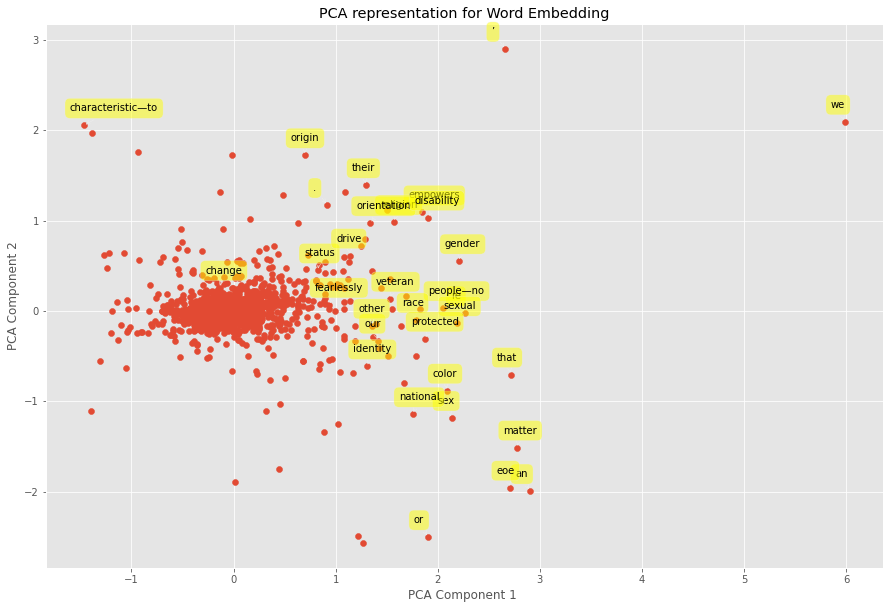

In [988]:
plt.scatter(viz_data[:,0],viz_data[:,1],cmap=plt.get_cmap('Spectral'))
for label,x,y in zip(words,viz_data[:,0],viz_data[:,1]):
    plt.annotate(
        label,
        xy=(x,y),
        xytext=(-14, 14),
        textcoords='offset points',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0')
    )
plt.xlabel('PCA Component 1 ')
plt.ylabel('PCA Component 2')
plt.title('PCA representation for Word Embedding')
#plt.xlim(-.05,..5)
#plt.ylim(-.1,.05)

In [637]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1,perplexity=3,method='exact')
tsne_results = tsne.fit_transform(return_matrix_)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 2202
[t-SNE] Computed conditional probabilities for sample 2000 / 2202
[t-SNE] Computed conditional probabilities for sample 2202 / 2202
[t-SNE] Mean sigma: 0.020826
[t-SNE] KL divergence after 250 iterations with early exaggeration: 92.007113
[t-SNE] KL divergence after 1000 iterations: 1.458509


Text(0.5, 1.0, 'TSNE representation for Word Embedding')

/Users/catalinmates/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 61623 missing from current font.

/Users/catalinmates/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 61623 missing from current font.



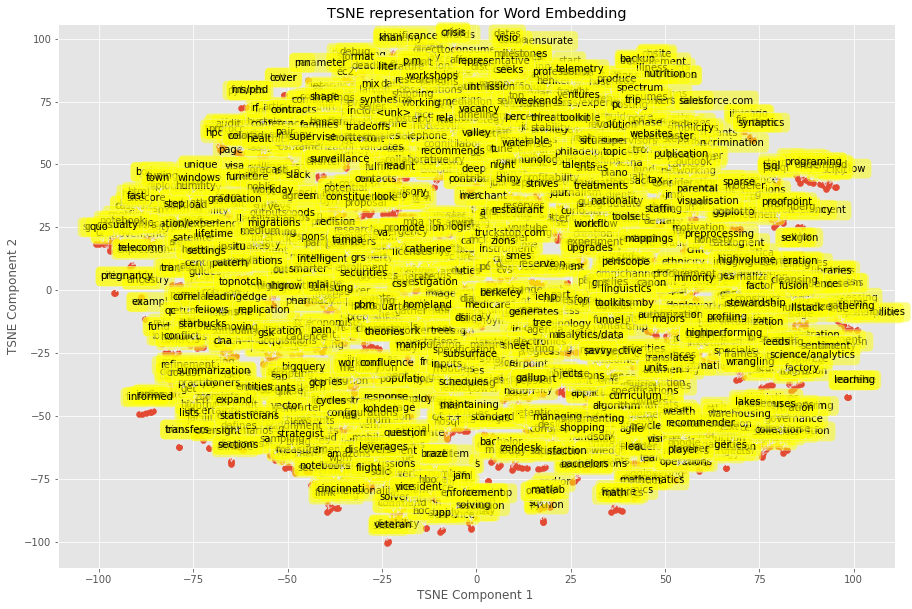

In [638]:
plt.scatter(tsne_results[:,0],tsne_results[:,1],cmap=plt.get_cmap('Spectral'))
for label,x,y in zip(words,tsne_results[:,0],tsne_results[:,1]):
    plt.annotate(
        label,
        xy=(x,y),
        xytext=(-14, 14),
        textcoords='offset points',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0')
    )
plt.xlabel('TSNE Component 1 ')
plt.ylabel('TSNE Component 2')
plt.title('TSNE representation for Word Embedding')


In [989]:
find_closest_embeddings(embeddings_dict["statistics"])[:10]


['statistics',
 'mathematics',
 'math',
 'computer',
 'field',
 'economics',
 'physics',
 'econometrics',
 'degree',
 'fields']

In [586]:
#chunk_unique = pd.read_csv("datascience_chunks_may16.csv")
chunk_unique

/Users/catalinmates/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning:

Columns (14,15,16,17) have mixed types.Specify dtype option on import or set low_memory=False.



Unnamed: 0                            0                     1  \
0                0        ('exploratory', 'NN')    ('research', 'NN')   
1                1           ('analysis', 'NN')                   NaN   
2                2          ('patterns', 'NNS')                   NaN   
3                3              ('data', 'NNS')                   NaN   
4                4           ('methods', 'NNS')                   NaN   
...            ...                          ...                   ...   
218437      218437        ('orientation', 'NN')                   NaN   
218438      218438             ('origin', 'NN')  ('disability', 'NN')   
218439      218439  ('characteristic—to', 'NN')                   NaN   
218440      218440             ('change', 'NN')                   NaN   
218441      218441                  (']', 'NN')                   NaN   

                        2                 3    4    5    6    7    8    9  \
0                     NaN               NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1                     NaN               NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2                     NaN               NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3                     NaN               NaN  NaN  NaN  NaN  NaN  NaN  NaN   
4                     NaN               NaN  NaN  NaN  NaN  NaN  NaN  NaN   
...                   ...               ...  ...  ...  ...  ...  ...  ...   
218437                NaN               NaN  NaN  NaN  NaN  NaN  NaN  NaN   
218438  ('veteran', 'NN')  ('status', 'NN')  NaN  NaN  NaN  NaN  NaN  NaN   
218439                NaN               NaN  NaN  NaN  NaN  NaN  NaN  NaN   
218440                NaN               NaN  NaN  NaN  NaN  NaN  NaN  NaN   
218441                NaN               NaN  NaN  NaN  NaN  NaN  NaN  NaN   

         10   11   12   13   14   15   16  
0       NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1       NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2       NaN  NaN  NaN  NaN  NaN  NaN  NaN  
3       NaN  NaN  NaN  NaN  NaN  NaN  NaN  
4       NaN  NaN  NaN  NaN  NaN  NaN  NaN  
...     ...  ...  ...  ...  ...  ...  ...  
218437  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
218438  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
218439  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
218440  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
218441  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[218442 rows x 18 columns]

In [34]:
combined_words = df_chunk_no_dups.combined_words
combined_list=[]

for word in combined_words:
    combined_list.append(word)
    
len(combined_list)

35702

In [35]:
with open('combined_list.txt', 'w') as filehandle:
    filehandle.writelines("%s\n" % place for place in combined_list)

In [36]:
len(combined_list)

35702

In [1129]:
embeddings_dict

{'data': array([-4.311170e-01,  8.503100e-01,  7.764240e-01, -1.630494e+00,
         6.061140e-01, -3.125200e-02,  4.649410e-01, -9.074050e-01,
        -8.983600e-02,  1.408361e+00,  2.548150e-01,  1.940574e+00,
        -1.786700e-01, -9.011890e-01, -1.198160e+00, -1.748506e+00,
        -6.840420e-01,  7.277170e-01,  2.422330e-01, -2.108000e-03,
         8.311000e-02, -3.976280e-01, -7.077590e-01, -2.287019e+00,
        -2.048522e+00,  4.335150e-01,  1.575200e-02, -1.039990e-01,
        -1.289387e+00,  7.282060e-01, -9.679090e-01,  3.892280e-01,
         3.771840e-01,  1.275560e-01, -2.171689e+00, -2.477920e-01,
        -2.564190e-01,  3.931620e-01, -7.136450e-01,  1.270302e+00,
         1.706661e+00,  5.857590e-01, -1.972320e-01,  1.653624e+00,
        -8.260270e-01, -7.454500e-01, -1.523422e+00, -9.424750e-01,
         8.264400e-01,  1.483342e+00], dtype=float32),
 'experience': array([ 0.002261,  0.301262,  0.156417, -0.542805,  1.222397, -0.357455,
         0.589258,  0.757287,  0.

# CNN + GLOVE

In [37]:
combined_list

['research',
 'analysis',
 'patterns',
 'data',
 'methods',
 'hypotheses',
 'relationships',
 'factors',
 'work',
 'business value',
 'combination',
 'technologies',
 'systems i.e',
 'gpu processing',
 'machine',
 'visualization system',
 'simulation',
 'results',
 'areas',
 'expertise',
 'statistics',
 'language processing',
 'learning optimization',
 'fields',
 'datasets',
 'relationships patterns',
 'trends',
 'data sets',
 'discover opportunities',
 'models',
 'algorithms',
 'data / business problems',
 'math',
 'extrapolate',
 'prescribe',
 'recommendations',
 'visualizations',
 'qualifications bachelors',
 'college',
 'mathematics science',
 'engineering',
 'years',
 'experience',
 'data science',
 'data analytics',
 'masters',
 'learner',
 'skills',
 'data engineering sw',
 'hw architecture',
 'qualifications job.qualifications',
 'martin',
 'action employer',
 'applicants',
 'consideration',
 'employment',
 'regard',
 'race color religion sex pregnancy',
 'orientation gender id

In [41]:
# Set Maximum number of words to be embedded
NUM_WORDS = 40000

# Define/Load Tokenize text function
tokenizer = Tokenizer(num_words=NUM_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'',
                      lower=True)

In [42]:
# Fit the function on the text
tokenizer.fit_on_texts(combined_list)

# Count number of unique tokens
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 10520 unique tokens.


In [996]:
# Find top words/tokens by frequency
#[pair[0] for pair in sorted(tokenizer.word_counts.items(), key=lambda item: item[1])]

In [997]:
# Convert train and val to sequence
sequences_train = tokenizer.texts_to_sequences(X_train_tech)
sequences_valid=tokenizer.texts_to_sequences(X_test_tech)

In [998]:
sequences_train[:5]

[[3, 422], [1, 781], [758], [95, 153, 30], [1, 130, 194]]

In [999]:
# pad documents to a max length of 4 words
max_length = 5
padded_docs_train_tech = pad_sequences(sequences_train, maxlen=max_length, padding='post')
padded_docs_test_tech = pad_sequences(sequences_valid, maxlen=max_length, padding='post')

print(padded_docs_train_tech)


[[   3  422    0    0    0]
 [   1  781    0    0    0]
 [ 758    0    0    0    0]
 ...
 [  56    1  169 4146 1933]
 [ 109  175    0    0    0]
 [  43  809  127  538    0]]


In [1000]:
max_list = []
for word in padded_docs_train_tech:
    max_list.append(word.max())

max_list[:5]

[422, 781, 758, 153, 194]

In [1001]:
test = pd.DataFrame(padded_docs_train_tech)
test.head()

0    1    2  3  4
0    3  422    0  0  0
1    1  781    0  0  0
2  758    0    0  0  0
3   95  153   30  0  0
4    1  130  194  0  0

In [1002]:
for i in range(0,4):
    print(test[i].max())

10398
9997
8939
10520


# Embeddings for full list of combined_words

In [38]:
len(combined_list)

35702

In [43]:
combined_list_matrix = tokenizer.texts_to_sequences(combined_list)
len(combined_list_matrix)

35702

In [44]:
combined_list_matrix_pad = pad_sequences(combined_list_matrix, padding='post')
combined_list_matrix_pad.shape

(35702, 22)

In [45]:
combined_list_df = pd.DataFrame(combined_list_matrix_pad)
combined_list_df.head()

0   1   2   3   4   5   6   7   8   9   ...  12  13  14  15  16  17  18  \
0   12   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
1   11   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
2  281   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
3    1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
4   98   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   

   19  20  21  
0   0   0   0  
1   0   0   0  
2   0   0   0  
3   0   0   0  
4   0   0   0  

[5 rows x 22 columns]

In [46]:
combined_list_df["combined_words"] = combined_list
combined_list_df[:5]

0  1  2  3  4  5  6  7  8  9  ...  13  14  15  16  17  18  19  20  21  \
0   12  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   
1   11  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   
2  281  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   
3    1  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   
4   98  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   

   combined_words  
0        research  
1        analysis  
2        patterns  
3            data  
4         methods  

[5 rows x 23 columns]

In [47]:
combined_list_df = combined_list_df.copy()[combined_list_df[5] == 0]

In [48]:
combined_list_df.shape

(35533, 23)

In [49]:
combined_list_df.drop(columns = [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21], inplace = True)
combined_list_df.head()

0  1  2  3  4 combined_words
0   12  0  0  0  0       research
1   11  0  0  0  0       analysis
2  281  0  0  0  0       patterns
3    1  0  0  0  0           data
4   98  0  0  0  0        methods

In [65]:
for i in range(5):
    combined_list_df['weights_' + str(i)] = ' '
    
    for j in combined_list_df[i].index:
        d = combined_list_df[i][j]

        combined_list_df['weights_' + str(i)][j] = embedding_matrix[d]

In [66]:
combined_list_df['weights_total'] = combined_list_df['weights_0'] + combined_list_df['weights_1'] + combined_list_df['weights_2'] + combined_list_df['weights_3'] + combined_list_df['weights_4']

combined_list_df.head()

0  1  2  3  4 combined_words  \
0   12  0  0  0  0       research   
1   11  0  0  0  0       analysis   
2  281  0  0  0  0       patterns   
3    1  0  0  0  0           data   
4   98  0  0  0  0        methods   

                                           weights_0  \
0  [-1.7860859632492065, -1.0075629949569702, 0.0...   
1  [-0.7500879764556885, 0.6995199918746948, 0.09...   
2  [-0.2237969934940338, 0.9505730271339417, 0.02...   
3  [-0.4311169981956482, 0.8503100275993347, 0.77...   
4  [-0.8885350227355957, 0.04422299936413765, 0.1...   

                                           weights_1  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                           weights_2  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                           weights_3  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                           weights_4  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                       weights_total  
0  [-1.7860859632492065, -1.0075629949569702, 0.0...  
1  [-0.7500879764556885, 0.6995199918746948, 0.09...  
2  [-0.2237969934940338, 0.9505730271339417, 0.02...  
3  [-0.4311169981956482, 0.8503100275993347, 0.77...  
4  [-0.8885350227355957, 0.04422299936413765, 0.1...

In [67]:
embeddings_dict["data"]

array([-4.311170e-01,  8.503100e-01,  7.764240e-01, -1.630494e+00,
        6.061140e-01, -3.125200e-02,  4.649410e-01, -9.074050e-01,
       -8.983600e-02,  1.408361e+00,  2.548150e-01,  1.940574e+00,
       -1.786700e-01, -9.011890e-01, -1.198160e+00, -1.748506e+00,
       -6.840420e-01,  7.277170e-01,  2.422330e-01, -2.108000e-03,
        8.311000e-02, -3.976280e-01, -7.077590e-01, -2.287019e+00,
       -2.048522e+00,  4.335150e-01,  1.575200e-02, -1.039990e-01,
       -1.289387e+00,  7.282060e-01, -9.679090e-01,  3.892280e-01,
        3.771840e-01,  1.275560e-01, -2.171689e+00, -2.477920e-01,
       -2.564190e-01,  3.931620e-01, -7.136450e-01,  1.270302e+00,
        1.706661e+00,  5.857590e-01, -1.972320e-01,  1.653624e+00,
       -8.260270e-01, -7.454500e-01, -1.523422e+00, -9.424750e-01,
        8.264400e-01,  1.483342e+00], dtype=float32)

In [1196]:
test = {}

test[combined_list_df['combined_words'][0]] = combined_list_df['weights_total'][0]
#test = {combined_list_df['combined_words']: combined_list_df['weights_total']}
test

{'research': array([-1.78608596, -1.00756299,  0.036961  , -1.34557903, -0.31148699,
        -0.83324301,  1.04397702,  0.22637101, -0.023096  ,  1.21124005,
        -1.03388298,  1.37197101, -0.34979901,  0.013565  , -0.78007001,
         0.62581599,  0.165732  ,  0.221071  ,  0.34621301,  0.232651  ,
         0.124633  ,  0.53734899, -0.74360597, -1.55183995, -0.31215   ,
        -0.75806803,  0.44790199, -0.113244  , -0.43054   , -0.906389  ,
        -0.13944601,  1.16706502,  0.243862  , -1.07232904, -0.65454   ,
        -0.64678103, -0.850878  , -0.51803899,  0.753878  , -0.44790599,
         1.93863499, -0.227098  , -0.27836701,  0.38158599, -0.76543498,
        -0.7044    , -0.63778198,  0.88867801, -0.021847  , -0.008216  ])}

In [68]:
combined_list_df_filter = combined_list_df[['combined_words','weights_total']]
combined_list_df_filter

combined_words  \
0                                   research   
1                                   analysis   
2                                   patterns   
3                                       data   
4                                    methods   
...                                      ...   
35697  risk management framework rmf ability   
35698      manage data science tasks ability   
35699    cs computer engineering mathematics   
35700                               java aws   
35701    certifications clearance applicants   

                                           weights_total  
0      [-1.7860859632492065, -1.0075629949569702, 0.0...  
1      [-0.7500879764556885, 0.6995199918746948, 0.09...  
2      [-0.2237969934940338, 0.9505730271339417, 0.02...  
3      [-0.4311169981956482, 0.8503100275993347, 0.77...  
4      [-0.8885350227355957, 0.04422299936413765, 0.1...  
...                                                  ...  
35697  [-0.6467860192060471, -0.032304972410202026, 0...  
35698  [-1.2267220169305801, 1.5051650181412697, 3.70...  
35699  [-2.3431229889392853, -0.9159120172262192, 1.2...  
35700  [1.243088960647583, 0.8430100083351135, 1.7203...  
35701  [0.9762709736824036, -0.20735301822423935, 0.0...  

[35533 rows x 2 columns]

In [70]:
combined_words_array = np.array(combined_list_df_filter["combined_words"])
weights_total_array = np.array(combined_list_df_filter["weights_total"])

embeddings_combined_words = {}
for combined, weight in zip(combined_words_array, weights_total_array):
    embeddings_combined_words[combined] = weight
    
embeddings_combined_words

{'research': array([-1.78608596, -1.00756299,  0.036961  , -1.34557903, -0.31148699,
        -0.83324301,  1.04397702,  0.22637101, -0.023096  ,  1.21124005,
        -1.03388298,  1.37197101, -0.34979901,  0.013565  , -0.78007001,
         0.62581599,  0.165732  ,  0.221071  ,  0.34621301,  0.232651  ,
         0.124633  ,  0.53734899, -0.74360597, -1.55183995, -0.31215   ,
        -0.75806803,  0.44790199, -0.113244  , -0.43054   , -0.906389  ,
        -0.13944601,  1.16706502,  0.243862  , -1.07232904, -0.65454   ,
        -0.64678103, -0.850878  , -0.51803899,  0.753878  , -0.44790599,
         1.93863499, -0.227098  , -0.27836701,  0.38158599, -0.76543498,
        -0.7044    , -0.63778198,  0.88867801, -0.021847  , -0.008216  ]),
 'analysis': array([-0.75008798,  0.69951999,  0.096103  , -0.41880101,  0.68496102,
         0.05668   ,  1.11161697, -0.70493001,  1.61237299,  0.074157  ,
        -0.65331697,  0.969558  , -0.90798497, -0.18198   , -1.21145105,
        -0.026674  , -0.2

In [74]:
test = find_closest_embeddings(embeddings_combined_words["machine learning"])[:10]

In [72]:
embeddings_combined_words['machine learning'].dot(embeddings_combined_words['machine'])

58.75671370216182

In [78]:
for word in test:
    print('Similarity score with ' + str(word) + ' :', cos_sim(embeddings_combined_words['machine learning'],embeddings_combined_words[word]))
    

Similarity score with machine : 0.9853087480077081
Similarity score with learning : 0.9831920794950273
Similarity score with techniques : 0.7863502226505233
Similarity score with models : 0.7107395811242778
Similarity score with algorithms : 0.7713653631370846
Similarity score with ml : 0.7349058144882208
Similarity score with methods : 0.6677316451894472
Similarity score with statistics : 0.6282583358596858
Similarity score with modeling : 0.6588734868679874
Similarity score with mining : 0.6374217772836276


In [1211]:
combined_list

['research',
 'analysis',
 'patterns',
 'data',
 'methods',
 'hypotheses',
 'relationships',
 'factors',
 'work',
 'business value',
 'combination',
 'technologies',
 'systems i.e',
 'gpu processing',
 'machine',
 'visualization system',
 'simulation',
 'results',
 'areas',
 'expertise',
 'statistics',
 'language processing',
 'learning optimization',
 'fields',
 'datasets',
 'relationships patterns',
 'trends',
 'data sets',
 'discover opportunities',
 'models',
 'algorithms',
 'data / business problems',
 'math',
 'extrapolate',
 'prescribe',
 'recommendations',
 'visualizations',
 'qualifications bachelors',
 'college',
 'mathematics science',
 'engineering',
 'years',
 'experience',
 'data science',
 'data analytics',
 'masters',
 'learner',
 'skills',
 'data engineering sw',
 'hw architecture',
 'qualifications job.qualifications',
 'martin',
 'action employer',
 'applicants',
 'consideration',
 'employment',
 'regard',
 'race color religion sex pregnancy',
 'orientation gender id

In [61]:
word_vectors = embeddings_dict

In [62]:
EMBEDDING_DIM=50
vocabulary_size=min(len(word_index)+1,(NUM_WORDS))

embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))


for word, i in word_index.items():
    if i>=NUM_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        vec = np.zeros(EMBEDDING_DIM)
        embedding_matrix[i]=vec

del(word_vectors)

In [63]:
embedding_matrix.shape

(10521, 50)

In [64]:
embedding_matrix[:5]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-4.31

In [1007]:
# Dfine Embedding function using the embedding_matrix
embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix])

In [1019]:
model = Sequential()
model.add(embedding_layer)

model.add(layers.Conv1D(128, 3, activation='relu'))


model.add(layers.GlobalMaxPool1D())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/Users/catalinmates/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



Training Accuracy: 0.9935
Testing Accuracy:  0.7833


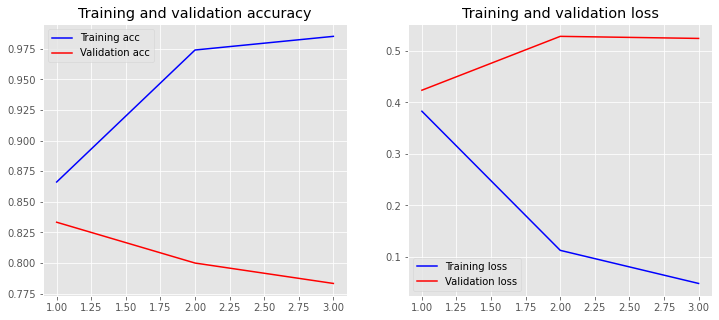

In [1020]:
history = model.fit(padded_docs_train_tech, y_train_tech,
                    epochs=3,
                    verbose=False,
                    validation_data=(padded_docs_test_tech, y_test_tech),
                    batch_size=10)

loss, accuracy = model.evaluate(padded_docs_train_tech, y_train_tech, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(padded_docs_test_tech, y_test_tech, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [1021]:
prediction_tech = model.predict(padded_docs_test_tech)

df_tech= pd.DataFrame(X_test_tech)
df_tech["skill_tech"] = y_test_tech
df_tech["prediction"] = prediction_tech.round(0)

actual_values = df_tech.skill_tech.values
predicted_values = df_tech.prediction.values.astype(int)

confusion = confusion_matrix(actual_values, predicted_values)
print(confusion)

tru_neg = confusion[0][0]
tru_pos = confusion[1][1]

fal_neg = confusion[1][0]
fal_pos = confusion[0][1]

neg = confusion[0][0] + confusion[0][1]
pos = confusion[1][0] + confusion[1][1]

print('\n' + "Skills accuracy: " + str(tru_pos/(tru_pos+fal_pos)))

print('\n' + "Not a skill accuracy: " + str(tru_neg/(tru_neg+fal_neg)))

[[43 12]
 [14 51]]

Skills accuracy: 0.8095238095238095

Not a skill accuracy: 0.7543859649122807


In [1022]:
df_tech[(df_tech['skill_tech'] == 0) & (df_tech['prediction'] == 1)]

combined_words  skill_tech  prediction
1013                 ssis informatics           0         1.0
44                  cise please click           0         1.0
49    drug development qualifications           0         1.0
901               analytics portfolio           0         1.0
425                 mdm server truist           0         1.0
566                  health functions           0         1.0
409                           jobs â€           0         1.0
70                  end user revenues           0         1.0
352                              user           0         1.0
1187                  papers software           0         1.0
837                        dress code           0         1.0
950                          liaisons           0         1.0

### GLOVE Embeddings

In [754]:
model_glove = Sequential()
embedding_layer_glove = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix])

model_glove.add(embedding_layer)
model_glove.compile('adam', 'mse')

In [755]:
model_glove.summary()


Model: "sequential_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_80 (Embedding)     multiple                  62050     
Total params: 62,050
Trainable params: 62,050
Non-trainable params: 0
_________________________________________________________________


In [759]:
input_data=[[0,1,2]]
input_data

[[0, 1, 2]]

In [760]:
model_glove.predict(input_data)


array([[[ 9.09062009e-03,  1.44310016e-03, -1.74835369e-01,
          2.94647571e-02, -6.48511481e-03,  8.19440112e-02,
          5.58797866e-02, -3.70087028e-02, -1.30364140e-02,
          1.13239493e-02,  1.57854669e-02,  1.51159950e-02,
          9.47057828e-03,  3.92963924e-02,  7.12011417e-04,
         -6.55730665e-02,  3.43187936e-02,  4.31112871e-02,
          2.22689230e-02,  9.52706498e-04, -9.49177705e-03,
         -5.46646379e-02, -2.93644145e-02,  1.07144909e-02,
          5.86752780e-02, -3.70888636e-02,  4.92173396e-02,
         -3.67734022e-02, -7.78329000e-02, -4.43558954e-03,
         -2.57000385e-04, -8.11252836e-03,  1.95477866e-02,
          6.67967796e-02, -1.25058331e-02,  3.81734595e-02,
         -9.86003131e-03, -1.53598469e-02, -1.09611368e-02,
          1.07743149e-03,  3.73567902e-02,  5.34166524e-04,
         -5.84698059e-02,  5.48949139e-03,  4.67403419e-03,
         -2.45501157e-02, -1.13864891e-01,  5.60830012e-02,
         -8.03084671e-03,  2.28916183e-0

In [764]:
embedding_layer.get_weights()

[array([[ 9.09062009e-03,  1.44310016e-03, -1.74835369e-01, ...,
          5.60830012e-02, -8.03084671e-03,  2.28916183e-02],
        [-1.62278548e-01,  1.22407508e+00,  1.36428088e-01, ...,
         -1.30795538e+00, -2.29025316e+00, -7.69301891e-01],
        [-1.03741443e+00, -1.69664383e-01,  2.55722374e-01, ...,
         -5.18022299e-01, -7.57808149e-01, -2.20147409e-02],
        ...,
        [ 4.54128198e-02,  2.69217212e-02,  7.84928799e-02, ...,
          7.78281409e-03,  6.72524348e-02,  4.32428420e-02],
        [-3.24946195e-02, -8.08016583e-03, -4.48853336e-02, ...,
         -2.56711640e-03, -1.37285935e-02,  2.44289283e-02],
        [-1.59081295e-02,  1.78137589e-02, -5.11216596e-02, ...,
          3.78154106e-02,  2.28402391e-02,  2.96863578e-02]], dtype=float32)]

## LSTM Test

In [89]:
STOPWORDS = set(stopwords.words('english'))

InteractiveShell.ast_node_interactivity = 'all'

cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

In [90]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 2000

MAX_SEQUENCE_LENGTH = 5

# This is the size of the vector space in which words will be embedded. 
# It defines the size of the output vectors from this layer for each word. 
EMBEDDING_DIM = 5

# This is the length of input sequences. 
#For example, if all of your input documents are comprised of 1000 words, this would be 1000.
INPUT_LENGTH = 5

max_len = 1

In [204]:
lstm_model = Sequential()
lstm_model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=5, dropout=0.2))
lstm_model.add(SpatialDropout1D(0.2))

lstm_model.add(LSTM(100, recurrent_dropout=0.2, dropout=0.2))
lstm_model.add(Dense(max_len))
lstm_model.add(Activation('relu'))

lstm_model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

lstm_model.summary()

/Users/pavel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning:

The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.



Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 5, 5)              1250000   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 5, 5)              0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               42400     
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 101       
_________________________________________________________________
activation_4 (Activation)    (None, 1)                 0         
Total params: 1,292,501
Trainable params: 1,292,501
Non-trainable params: 0
_________________________________________________________________


In [205]:
history = lstm_model.fit(padded_docs_train_tech, y_train_tech, epochs=10, batch_size=5 ,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

/Users/pavel/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.

/Users/pavel/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



Train on 860 samples, validate on 216 samples
Epoch 1/10
860/860 [==============================] - 3s 4ms/step - loss: 7.7663 - accuracy: 0.4965 - val_loss: 7.2840 - val_accuracy: 0.5278
Epoch 2/10
860/860 [==============================] - 2s 3ms/step - loss: 7.7663 - accuracy: 0.4965 - val_loss: 7.2840 - val_accuracy: 0.5278
Epoch 3/10
860/860 [==============================] - 2s 3ms/step - loss: 7.7663 - accuracy: 0.4965 - val_loss: 7.2840 - val_accuracy: 0.5278
Epoch 4/10
860/860 [==============================] - 2s 3ms/step - loss: 7.7663 - accuracy: 0.4965 - val_loss: 7.2840 - val_accuracy: 0.5278


In [206]:
lstm_predict_tech = lstm_model.predict(padded_docs_test_tech)

df_lstm_tech= pd.DataFrame(X_test_tech)
df_lstm_tech["skill_tech"] = y_test_tech
df_lstm_tech["prediction"] = lstm_predict_tech.round(0)

lstm_actual = df_lstm_tech.skill_tech.values
lstm_predict_tech = df_lstm_tech.prediction.values.astype(int)

lstm_confusion = confusion_matrix(lstm_actual, lstm_predict_tech)
print(lstm_confusion)

[[57  0]
 [63  0]]


In [140]:
df_lstm_tech["prediction_rounded"] = lstm_predict_tech.round(2)

In [141]:
df_lstm_tech.head(5)

combined_words  skill_tech  prediction  prediction_rounded
636           python java scala           1         0.0                   0
243             culture thrives           0         0.0                   0
1013         xgboost tensorflow           1         0.0                   0
1113  business decisions design           1         0.0                   0
58                    level sas           1         0.0                   0

In [142]:
df_lstm_tech["prediction_adj"] = df_lstm_tech["prediction_rounded"].apply(lambda x: 0 if x <= .4 else 1 )
df_lstm_tech.head(1)

combined_words  skill_tech  prediction  prediction_rounded  \
636  python java scala           1         0.0                   0   

     prediction_adj  
636               0

In [207]:
score,acc = lstm_model.evaluate(padded_docs_test_tech, y_test_tech, verbose = 2, batch_size = 5)

print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

score: 8.10
acc: 0.47


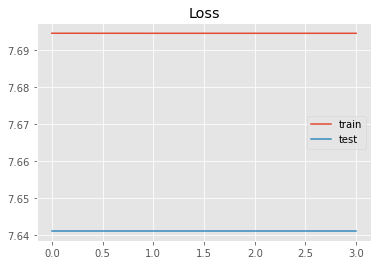

In [144]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

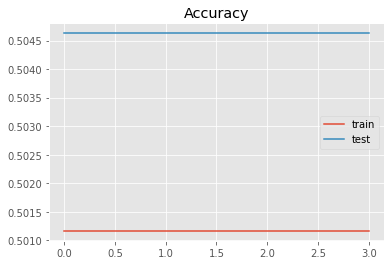

In [145]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

### Lenght of chunks 

In [106]:
test = pd.DataFrame(X_train_tech.reset_index(drop = True))
test['word_count'] = test['combined_words'].apply(lambda x: len(word_tokenize(x)))
test[:5]

combined_words  word_count
0                 learning models familiarity           3
1                                     knowhow           1
2                data processing technologies           3
3                            health plan data           3
4  employment opportunity statement travelers           4

In [107]:
test.word_count.median()

2.0

In [108]:
test.word_count.mean()

2.3680297397769516

## Soft skills version: 20 vs 80 split


In [ ]:
X_train_soft, X_test_soft, y_train_soft, y_test_soft = train_test_split(df_chunk["combined_words"], df_chunk["Soft"], test_size=0.2, random_state=42)
X_train_soft.shape

vocab_size = 250000
encoded_docs_train_soft = [one_hot(d, vocab_size) for d in X_train_soft]

# pad documents to a max length of 4 words
max_length = 5
padded_docs_train_soft = pad_sequences(encoded_docs_train_soft, maxlen=max_length, padding='post')
print(padded_docs_train_soft)

encoded_docs_test_soft = [one_hot(d, vocab_size) for d in X_test_soft]

padded_docs_test_soft = pad_sequences(encoded_docs_test_soft, maxlen=max_length, padding='post')
#print(padded_docs_test)

# define the model
model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=max_length))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())

# fit the model
model.fit(padded_docs_train_soft, y_train_soft, epochs=20, verbose=0)

model_soft = model.fit(padded_docs_train_soft, y_train_soft, epochs=25, validation_data = (padded_docs_test_soft, y_test_soft), verbose=2)

#model.save('CNN_soft_may18_10pct.model')

prediction_soft = model.predict(padded_docs_test_soft)

df_soft= pd.DataFrame(X_test_soft)
df_soft["skill_soft"] = y_test_soft
df_soft["prediction"] = prediction_soft.round(0)
df_soft.shape

actual_values = df_soft.skill_soft.values
predicted_values = df_soft.prediction.values.astype(int)

confusion = confusion_matrix(actual_values, predicted_values)
print(confusion)

# Test full dataset

In [146]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 250000

MAX_SEQUENCE_LENGTH = 5

# This is the size of the vector space in which words will be embedded. 
# It defines the size of the output vectors from this layer for each word. 
EMBEDDING_DIM = 5

# This is the length of input sequences. 
#For example, if all of your input documents are comprised of 1000 words, this would be 1000.
INPUT_LENGTH = 5

#max_len = 1

lstm_model = Sequential()
lstm_model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=5, dropout=0.2))
lstm_model.add(SpatialDropout1D(0.2))

lstm_model.add(LSTM(100, recurrent_dropout=0.2, dropout=0.2))
lstm_model.add(Dense(max_len))
lstm_model.add(Activation('relu'))

lstm_model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

lstm_model.summary()

/Users/pavel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning:

The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.



Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 5, 5)              1250000   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 5, 5)              0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               42400     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 101       
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total params: 1,292,501
Trainable params: 1,292,501
Non-trainable params: 0
_________________________________________________________________


In [121]:
vocab_size = 250000
encoded_docs_train = [one_hot(d, vocab_size) for d in df_chunk_df_no_dups["combined_words"]]

In [122]:
# pad documents to a max length of 4 words
max_length = 5
padded_docs_train = pad_sequences(encoded_docs_train, maxlen=max_length, padding='post')
print(padded_docs_train)

[[192866      0      0      0      0]
 [ 73967      0      0      0      0]
 [165343      0      0      0      0]
 ...
 [ 45381 149336 247078  40838      0]
 [227104  71587      0      0      0]
 [219345  24761 147270      0      0]]


In [147]:
prediction_full = lstm_model.predict(padded_docs_train)
prediction_full.shape

(35701, 1)

In [125]:
df_chunk_no_dups["prediction"] = prediction_full.round(2)
df_chunk_no_dups[:5]

word_1 word_2 word_3 word_4 word_5 combined_words  prediction
0  research                                   research        0.01
1  analysis                                   analysis        0.01
2  patterns                                   patterns        0.01
3      data                                       data        0.01
4   methods                                    methods        0.01

In [127]:
df_skill_predict = df_chunk_no_dups[df_chunk_no_dups["prediction"] >= .8]
df_noskill_predict = df_chunk_no_dups[df_chunk_no_dups["prediction"] <= .2]

In [132]:
df_skill_predict[:10]

Empty DataFrame
Columns: [word_1, word_2, word_3, word_4, word_5, combined_words, prediction]
Index: []

In [133]:
df_predict = pd.DataFrame(df_skill_predict.groupby(["combined_words", "prediction"]).count()["word_1"].sort_values(ascending = False)).reset_index().rename(columns = {'word_1' : "count"})

df_predict[:10]


Empty DataFrame
Columns: [combined_words, prediction, count]
Index: []